In [2]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tf
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1,2'

Using TensorFlow backend.


# Initialize the setting

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [4]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 20 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 45 # the number of class
        self.feat_d = 190
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/FPHAB/'
C = Config()

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=20,joint_d=3,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [6]:
def build_DD_Net(frame_l=32,joint_n=20,joint_d=3,feat_d=231,clc_num=45,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))   #32,231
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) #32,22,3
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters) #32,22,3,231,16
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [7]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters) #32,22,3,231,14,64

In [8]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 190)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 20, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1733376     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

## load data

In [9]:
Train = pickle.load(open(C.data_dir+"train_310.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test_310.pkl", "rb"))

## Without frame_sampling train

In [10]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['label'][i]-1] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  #(1960,32,231) ndarray
X_1 = np.stack(X_1)  #(1960,32,22,3)
Y = np.stack(Y)

100%|████████████████████████████████████████| 783/783 [00:06<00:00, 117.37it/s]


In [11]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 392/392 [00:03<00:00, 120.08it/s]


In [12]:
# it may takes several times to reach the reported performance
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,  
            batch_size=len(Y),
            epochs=600, #600
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 783 samples, validate on 392 samples
Epoch 1/600
783/783 [==============================] - 7s 8ms/step - loss: 4.4990 - accuracy: 0.0192 - val_loss: 5.2240 - val_accuracy: 0.0230
Epoch 2/600
783/783 [==============================] - 0s 141us/step - loss: 4.1214 - accuracy: 0.0358 - val_loss: 5.9599 - val_accuracy: 0.0459
Epoch 3/600
783/783 [==============================] - 0s 121us/step - loss: 4.0127 - accuracy: 0.0473 - val_loss: 7.3581 - val_accuracy: 0.0281
Epoch 4/600
783/783 [==============================] - 0s 117us/step - loss: 3.8097 - accuracy: 0.0779 - val_loss: 8.6126 - val_accuracy: 0.0281
Epoch 5/600
783/783 [==============================] - 0s 115us/step - loss: 3.6353 - accuracy: 0.0932 - val_loss: 9.9473 - val_accuracy: 0.0306
Epoch 6/600
783/783 [==============================] - 0s 118us/step - loss: 3.4498 - accuracy: 0.1213 - val_loss: 11.0848 - val_accuracy: 0.0357
Epoch 7/600
783/783 [==============================] - 0s 122us/step - loss: 3.3698 -

Epoch 57/600
783/783 [==============================] - 0s 142us/step - loss: 0.8973 - accuracy: 0.8455 - val_loss: 2.8118 - val_accuracy: 0.2730
Epoch 58/600
783/783 [==============================] - 0s 126us/step - loss: 0.8968 - accuracy: 0.8212 - val_loss: 2.7897 - val_accuracy: 0.2857
Epoch 59/600
783/783 [==============================] - 0s 127us/step - loss: 0.8413 - accuracy: 0.8455 - val_loss: 2.7480 - val_accuracy: 0.2985
Epoch 60/600
783/783 [==============================] - 0s 127us/step - loss: 0.8078 - accuracy: 0.8621 - val_loss: 2.6994 - val_accuracy: 0.3316
Epoch 61/600
783/783 [==============================] - 0s 127us/step - loss: 0.8252 - accuracy: 0.8531 - val_loss: 2.6572 - val_accuracy: 0.3648
Epoch 62/600
783/783 [==============================] - 0s 130us/step - loss: 0.7751 - accuracy: 0.8646 - val_loss: 2.6170 - val_accuracy: 0.3878
Epoch 63/600
783/783 [==============================] - 0s 132us/step - loss: 0.8096 - accuracy: 0.8519 - val_loss: 2.5893 -

783/783 [==============================] - 0s 131us/step - loss: 0.2451 - accuracy: 0.9732 - val_loss: 1.0627 - val_accuracy: 0.7577
Epoch 114/600
783/783 [==============================] - 0s 134us/step - loss: 0.2292 - accuracy: 0.9757 - val_loss: 1.0430 - val_accuracy: 0.7679
Epoch 115/600
783/783 [==============================] - 0s 134us/step - loss: 0.2410 - accuracy: 0.9796 - val_loss: 1.0257 - val_accuracy: 0.7806
Epoch 116/600
783/783 [==============================] - 0s 130us/step - loss: 0.2525 - accuracy: 0.9681 - val_loss: 1.0230 - val_accuracy: 0.7806
Epoch 117/600
783/783 [==============================] - 0s 131us/step - loss: 0.2487 - accuracy: 0.9757 - val_loss: 1.0582 - val_accuracy: 0.7755
Epoch 118/600
783/783 [==============================] - 0s 134us/step - loss: 0.2181 - accuracy: 0.9847 - val_loss: 1.1378 - val_accuracy: 0.7398
Epoch 119/600
783/783 [==============================] - 0s 131us/step - loss: 0.2403 - accuracy: 0.9757 - val_loss: 1.1790 - val_ac

Epoch 169/600
783/783 [==============================] - 0s 127us/step - loss: 0.1343 - accuracy: 0.9834 - val_loss: 0.4267 - val_accuracy: 0.9133
Epoch 170/600
783/783 [==============================] - 0s 133us/step - loss: 0.1234 - accuracy: 0.9936 - val_loss: 0.4208 - val_accuracy: 0.9158
Epoch 171/600
783/783 [==============================] - 0s 134us/step - loss: 0.1303 - accuracy: 0.9936 - val_loss: 0.4146 - val_accuracy: 0.9133
Epoch 172/600
783/783 [==============================] - 0s 130us/step - loss: 0.1232 - accuracy: 0.9936 - val_loss: 0.4088 - val_accuracy: 0.9133
Epoch 173/600
783/783 [==============================] - 0s 139us/step - loss: 0.1401 - accuracy: 0.9872 - val_loss: 0.4021 - val_accuracy: 0.9133
Epoch 174/600
783/783 [==============================] - 0s 135us/step - loss: 0.1332 - accuracy: 0.9923 - val_loss: 0.3960 - val_accuracy: 0.9133
Epoch 175/600
783/783 [==============================] - 0s 129us/step - loss: 0.1157 - accuracy: 0.9962 - val_loss: 0

Epoch 225/600
783/783 [==============================] - 0s 128us/step - loss: 0.1177 - accuracy: 0.9898 - val_loss: 0.2399 - val_accuracy: 0.9413
Epoch 226/600
783/783 [==============================] - 0s 135us/step - loss: 0.1209 - accuracy: 0.9923 - val_loss: 0.2387 - val_accuracy: 0.9413
Epoch 227/600
783/783 [==============================] - 0s 147us/step - loss: 0.1105 - accuracy: 0.9949 - val_loss: 0.2375 - val_accuracy: 0.9413
Epoch 228/600
783/783 [==============================] - 0s 140us/step - loss: 0.1243 - accuracy: 0.9936 - val_loss: 0.2363 - val_accuracy: 0.9413
Epoch 229/600
783/783 [==============================] - 0s 132us/step - loss: 0.1189 - accuracy: 0.9936 - val_loss: 0.2351 - val_accuracy: 0.9413
Epoch 230/600
783/783 [==============================] - 0s 134us/step - loss: 0.1297 - accuracy: 0.9911 - val_loss: 0.2340 - val_accuracy: 0.9413
Epoch 231/600
783/783 [==============================] - 0s 143us/step - loss: 0.1362 - accuracy: 0.9898 - val_loss: 0

Epoch 281/600
783/783 [==============================] - 0s 136us/step - loss: 0.1135 - accuracy: 0.9872 - val_loss: 0.1969 - val_accuracy: 0.9464
Epoch 282/600
783/783 [==============================] - 0s 139us/step - loss: 0.1274 - accuracy: 0.9898 - val_loss: 0.1965 - val_accuracy: 0.9464
Epoch 283/600
783/783 [==============================] - 0s 129us/step - loss: 0.1171 - accuracy: 0.9987 - val_loss: 0.1961 - val_accuracy: 0.9464
Epoch 284/600
783/783 [==============================] - 0s 134us/step - loss: 0.1425 - accuracy: 0.9898 - val_loss: 0.1958 - val_accuracy: 0.9464
Epoch 285/600
783/783 [==============================] - 0s 135us/step - loss: 0.1146 - accuracy: 0.9936 - val_loss: 0.1954 - val_accuracy: 0.9464
Epoch 286/600
783/783 [==============================] - 0s 135us/step - loss: 0.1207 - accuracy: 0.9949 - val_loss: 0.1950 - val_accuracy: 0.9464
Epoch 287/600
783/783 [==============================] - 0s 134us/step - loss: 0.1348 - accuracy: 0.9923 - val_loss: 0

Epoch 337/600
783/783 [==============================] - 0s 143us/step - loss: 0.1274 - accuracy: 0.9885 - val_loss: 0.1817 - val_accuracy: 0.9566
Epoch 338/600
783/783 [==============================] - 0s 141us/step - loss: 0.1206 - accuracy: 0.9974 - val_loss: 0.1816 - val_accuracy: 0.9566
Epoch 339/600
783/783 [==============================] - 0s 131us/step - loss: 0.1323 - accuracy: 0.9898 - val_loss: 0.1815 - val_accuracy: 0.9566
Epoch 340/600
783/783 [==============================] - 0s 132us/step - loss: 0.1165 - accuracy: 0.9923 - val_loss: 0.1813 - val_accuracy: 0.9566
Epoch 341/600
783/783 [==============================] - 0s 135us/step - loss: 0.1316 - accuracy: 0.9962 - val_loss: 0.1812 - val_accuracy: 0.9566
Epoch 342/600
783/783 [==============================] - 0s 132us/step - loss: 0.1248 - accuracy: 0.9885 - val_loss: 0.1811 - val_accuracy: 0.9566
Epoch 343/600
783/783 [==============================] - 0s 134us/step - loss: 0.1008 - accuracy: 0.9949 - val_loss: 0

Epoch 393/600
783/783 [==============================] - 0s 143us/step - loss: 0.1217 - accuracy: 0.9923 - val_loss: 0.1750 - val_accuracy: 0.9566
Epoch 394/600
783/783 [==============================] - 0s 149us/step - loss: 0.1274 - accuracy: 0.9962 - val_loss: 0.1749 - val_accuracy: 0.9566
Epoch 395/600
783/783 [==============================] - 0s 137us/step - loss: 0.1174 - accuracy: 0.9962 - val_loss: 0.1748 - val_accuracy: 0.9566
Epoch 396/600
783/783 [==============================] - 0s 136us/step - loss: 0.1242 - accuracy: 0.9936 - val_loss: 0.1748 - val_accuracy: 0.9566
Epoch 397/600
783/783 [==============================] - 0s 145us/step - loss: 0.1104 - accuracy: 0.9949 - val_loss: 0.1747 - val_accuracy: 0.9566
Epoch 398/600
783/783 [==============================] - 0s 143us/step - loss: 0.1162 - accuracy: 0.9936 - val_loss: 0.1747 - val_accuracy: 0.9566
Epoch 399/600
783/783 [==============================] - 0s 136us/step - loss: 0.1171 - accuracy: 0.9949 - val_loss: 0

Epoch 449/600
783/783 [==============================] - 0s 118us/step - loss: 0.1193 - accuracy: 0.9911 - val_loss: 0.1728 - val_accuracy: 0.9541
Epoch 450/600
783/783 [==============================] - 0s 123us/step - loss: 0.1240 - accuracy: 0.9923 - val_loss: 0.1727 - val_accuracy: 0.9515
Epoch 451/600
783/783 [==============================] - 0s 123us/step - loss: 0.1165 - accuracy: 0.9911 - val_loss: 0.1727 - val_accuracy: 0.9515
Epoch 452/600
783/783 [==============================] - 0s 121us/step - loss: 0.1204 - accuracy: 0.9898 - val_loss: 0.1726 - val_accuracy: 0.9515
Epoch 453/600
783/783 [==============================] - 0s 121us/step - loss: 0.1233 - accuracy: 0.9962 - val_loss: 0.1726 - val_accuracy: 0.9515
Epoch 454/600
783/783 [==============================] - 0s 128us/step - loss: 0.1169 - accuracy: 0.9923 - val_loss: 0.1726 - val_accuracy: 0.9515
Epoch 455/600
783/783 [==============================] - 0s 125us/step - loss: 0.1286 - accuracy: 0.9898 - val_loss: 0

Epoch 505/600
783/783 [==============================] - 0s 134us/step - loss: 0.1251 - accuracy: 0.9923 - val_loss: 0.1706 - val_accuracy: 0.9515
Epoch 506/600
783/783 [==============================] - 0s 130us/step - loss: 0.1211 - accuracy: 0.9911 - val_loss: 0.1706 - val_accuracy: 0.9515
Epoch 507/600
783/783 [==============================] - 0s 133us/step - loss: 0.1233 - accuracy: 0.9923 - val_loss: 0.1706 - val_accuracy: 0.9515
Epoch 508/600
783/783 [==============================] - 0s 134us/step - loss: 0.1169 - accuracy: 0.9923 - val_loss: 0.1706 - val_accuracy: 0.9515
Epoch 509/600
783/783 [==============================] - 0s 130us/step - loss: 0.1158 - accuracy: 0.9962 - val_loss: 0.1706 - val_accuracy: 0.9515
Epoch 510/600
783/783 [==============================] - 0s 131us/step - loss: 0.1317 - accuracy: 0.9936 - val_loss: 0.1706 - val_accuracy: 0.9515
Epoch 511/600
783/783 [==============================] - 0s 135us/step - loss: 0.1180 - accuracy: 0.9911 - val_loss: 0

Epoch 561/600
783/783 [==============================] - 0s 135us/step - loss: 0.1133 - accuracy: 0.9974 - val_loss: 0.1694 - val_accuracy: 0.9541
Epoch 562/600
783/783 [==============================] - 0s 134us/step - loss: 0.1123 - accuracy: 0.9936 - val_loss: 0.1694 - val_accuracy: 0.9541
Epoch 563/600
783/783 [==============================] - 0s 137us/step - loss: 0.1208 - accuracy: 0.9923 - val_loss: 0.1694 - val_accuracy: 0.9541
Epoch 564/600
783/783 [==============================] - 0s 140us/step - loss: 0.1223 - accuracy: 0.9974 - val_loss: 0.1694 - val_accuracy: 0.9541
Epoch 565/600
783/783 [==============================] - 0s 139us/step - loss: 0.1084 - accuracy: 0.9936 - val_loss: 0.1694 - val_accuracy: 0.9541
Epoch 566/600
783/783 [==============================] - 0s 132us/step - loss: 0.1108 - accuracy: 0.9936 - val_loss: 0.1693 - val_accuracy: 0.9541
Epoch 567/600
783/783 [==============================] - 0s 143us/step - loss: 0.1152 - accuracy: 0.9936 - val_loss: 0

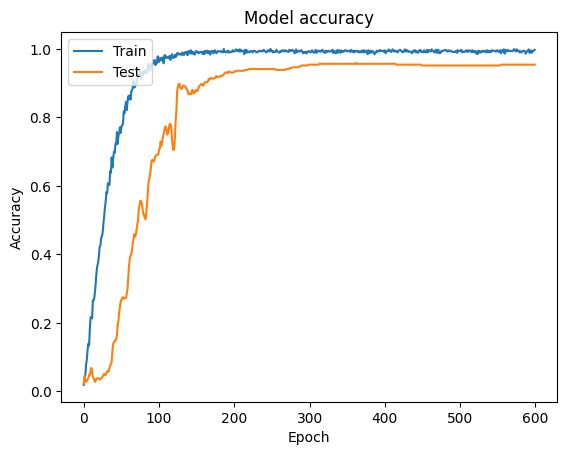

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_310_test1.png")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
# DD_Net.save_weights('weights/coarse_heavy.h1')

In [15]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [16]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [17]:
#from sklearn.metrics import accuracy_score
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9540816326530612


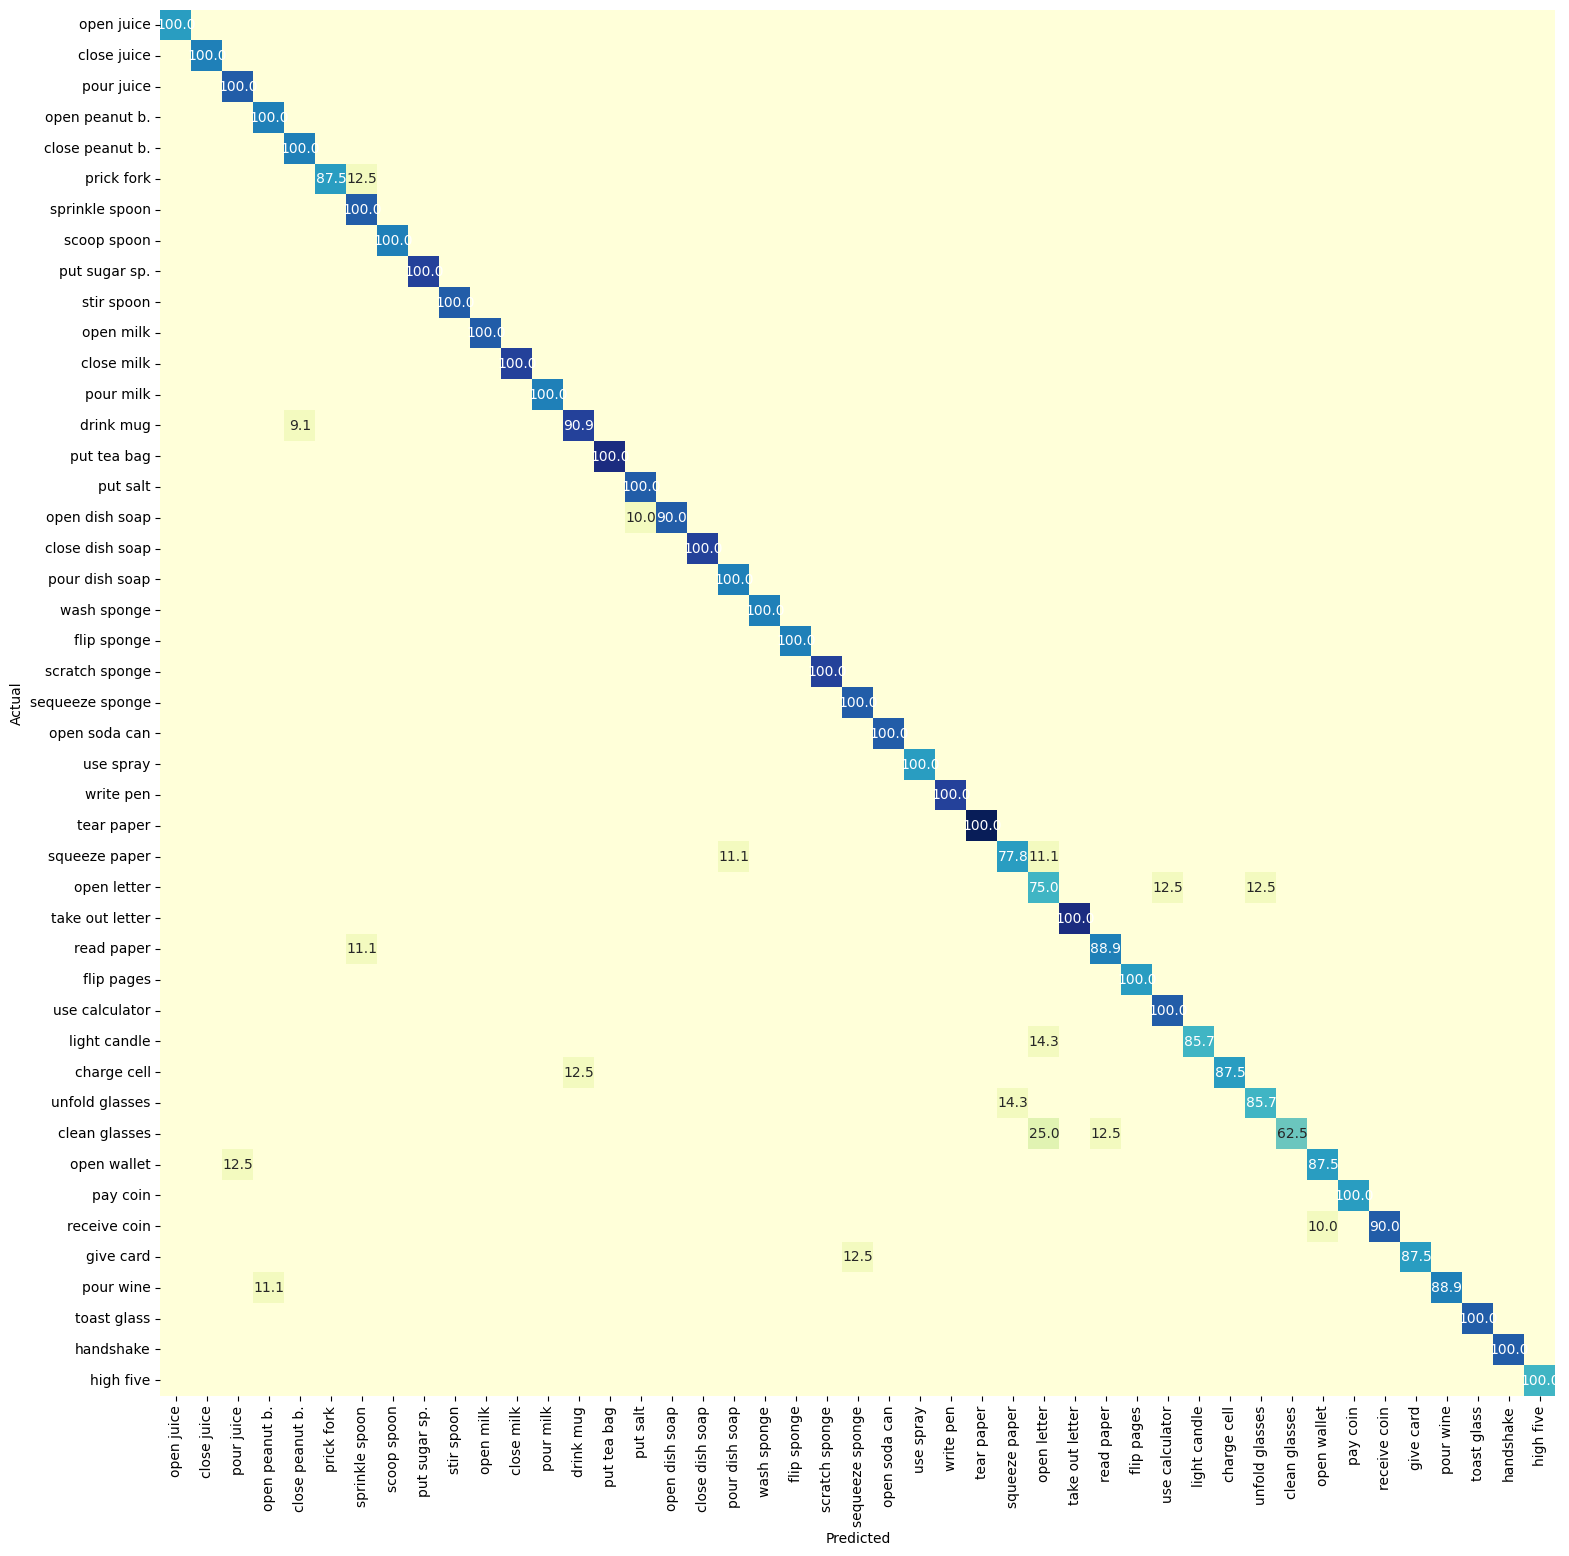

In [18]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test2.png', labels, ymap=None, figsize=(18,18))

## Training with frame_sampling

In [19]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [20]:
epochs = 20  #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,20,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net_model = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 116.46it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 4s 5ms/step - loss: 0.1229 - accuracy: 0.9936 - val_loss: 0.1686 - val_accuracy: 0.9541
epoch1


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 122.26it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 124us/step - loss: 0.1335 - accuracy: 0.9860 - val_loss: 0.1681 - val_accuracy: 0.9566
epoch2


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 119.38it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 158us/step - loss: 0.1339 - accuracy: 0.9898 - val_loss: 0.1677 - val_accuracy: 0.9566
epoch3


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 118.83it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 133us/step - loss: 0.1217 - accuracy: 0.9911 - val_loss: 0.1674 - val_accuracy: 0.9566
epoch4


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 114.87it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 143us/step - loss: 0.1338 - accuracy: 0.9936 - val_loss: 0.1671 - val_accuracy: 0.9566
epoch5


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 115.20it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 149us/step - loss: 0.1182 - accuracy: 0.9911 - val_loss: 0.1670 - val_accuracy: 0.9566
epoch6


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 124.29it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 151us/step - loss: 0.1195 - accuracy: 0.9949 - val_loss: 0.1668 - val_accuracy: 0.9566
epoch7


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 124.68it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 131us/step - loss: 0.1252 - accuracy: 0.9885 - val_loss: 0.1667 - val_accuracy: 0.9566
epoch8


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 122.08it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 159us/step - loss: 0.1216 - accuracy: 0.9885 - val_loss: 0.1665 - val_accuracy: 0.9566
epoch9


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 125.91it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 133us/step - loss: 0.1311 - accuracy: 0.9898 - val_loss: 0.1663 - val_accuracy: 0.9566
epoch10


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 123.56it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 126us/step - loss: 0.1372 - accuracy: 0.9923 - val_loss: 0.1661 - val_accuracy: 0.9592
epoch11


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 123.92it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 132us/step - loss: 0.1111 - accuracy: 0.9974 - val_loss: 0.1660 - val_accuracy: 0.9592
epoch12


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 123.92it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 140us/step - loss: 0.1213 - accuracy: 0.9936 - val_loss: 0.1658 - val_accuracy: 0.9592
epoch13


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 124.19it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 124us/step - loss: 0.1335 - accuracy: 0.9860 - val_loss: 0.1656 - val_accuracy: 0.9592
epoch14


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 124.77it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 137us/step - loss: 0.1132 - accuracy: 0.9974 - val_loss: 0.1655 - val_accuracy: 0.9592
epoch15


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 124.29it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 126us/step - loss: 0.1363 - accuracy: 0.9860 - val_loss: 0.1655 - val_accuracy: 0.9592
epoch16


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 121.87it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 126us/step - loss: 0.1143 - accuracy: 0.9962 - val_loss: 0.1653 - val_accuracy: 0.9592
epoch17


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 122.58it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 132us/step - loss: 0.1213 - accuracy: 0.9911 - val_loss: 0.1652 - val_accuracy: 0.9592
epoch18


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 119.56it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 131us/step - loss: 0.1290 - accuracy: 0.9898 - val_loss: 0.1652 - val_accuracy: 0.9592
epoch19


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 120.94it/s]


Train on 783 samples, validate on 392 samples
Epoch 1/1
783/783 [==============================] - 0s 151us/step - loss: 0.1128 - accuracy: 0.9962 - val_loss: 0.1652 - val_accuracy: 0.9592


# Plotting confusion matrix

In [21]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [22]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [23]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9591836734693877


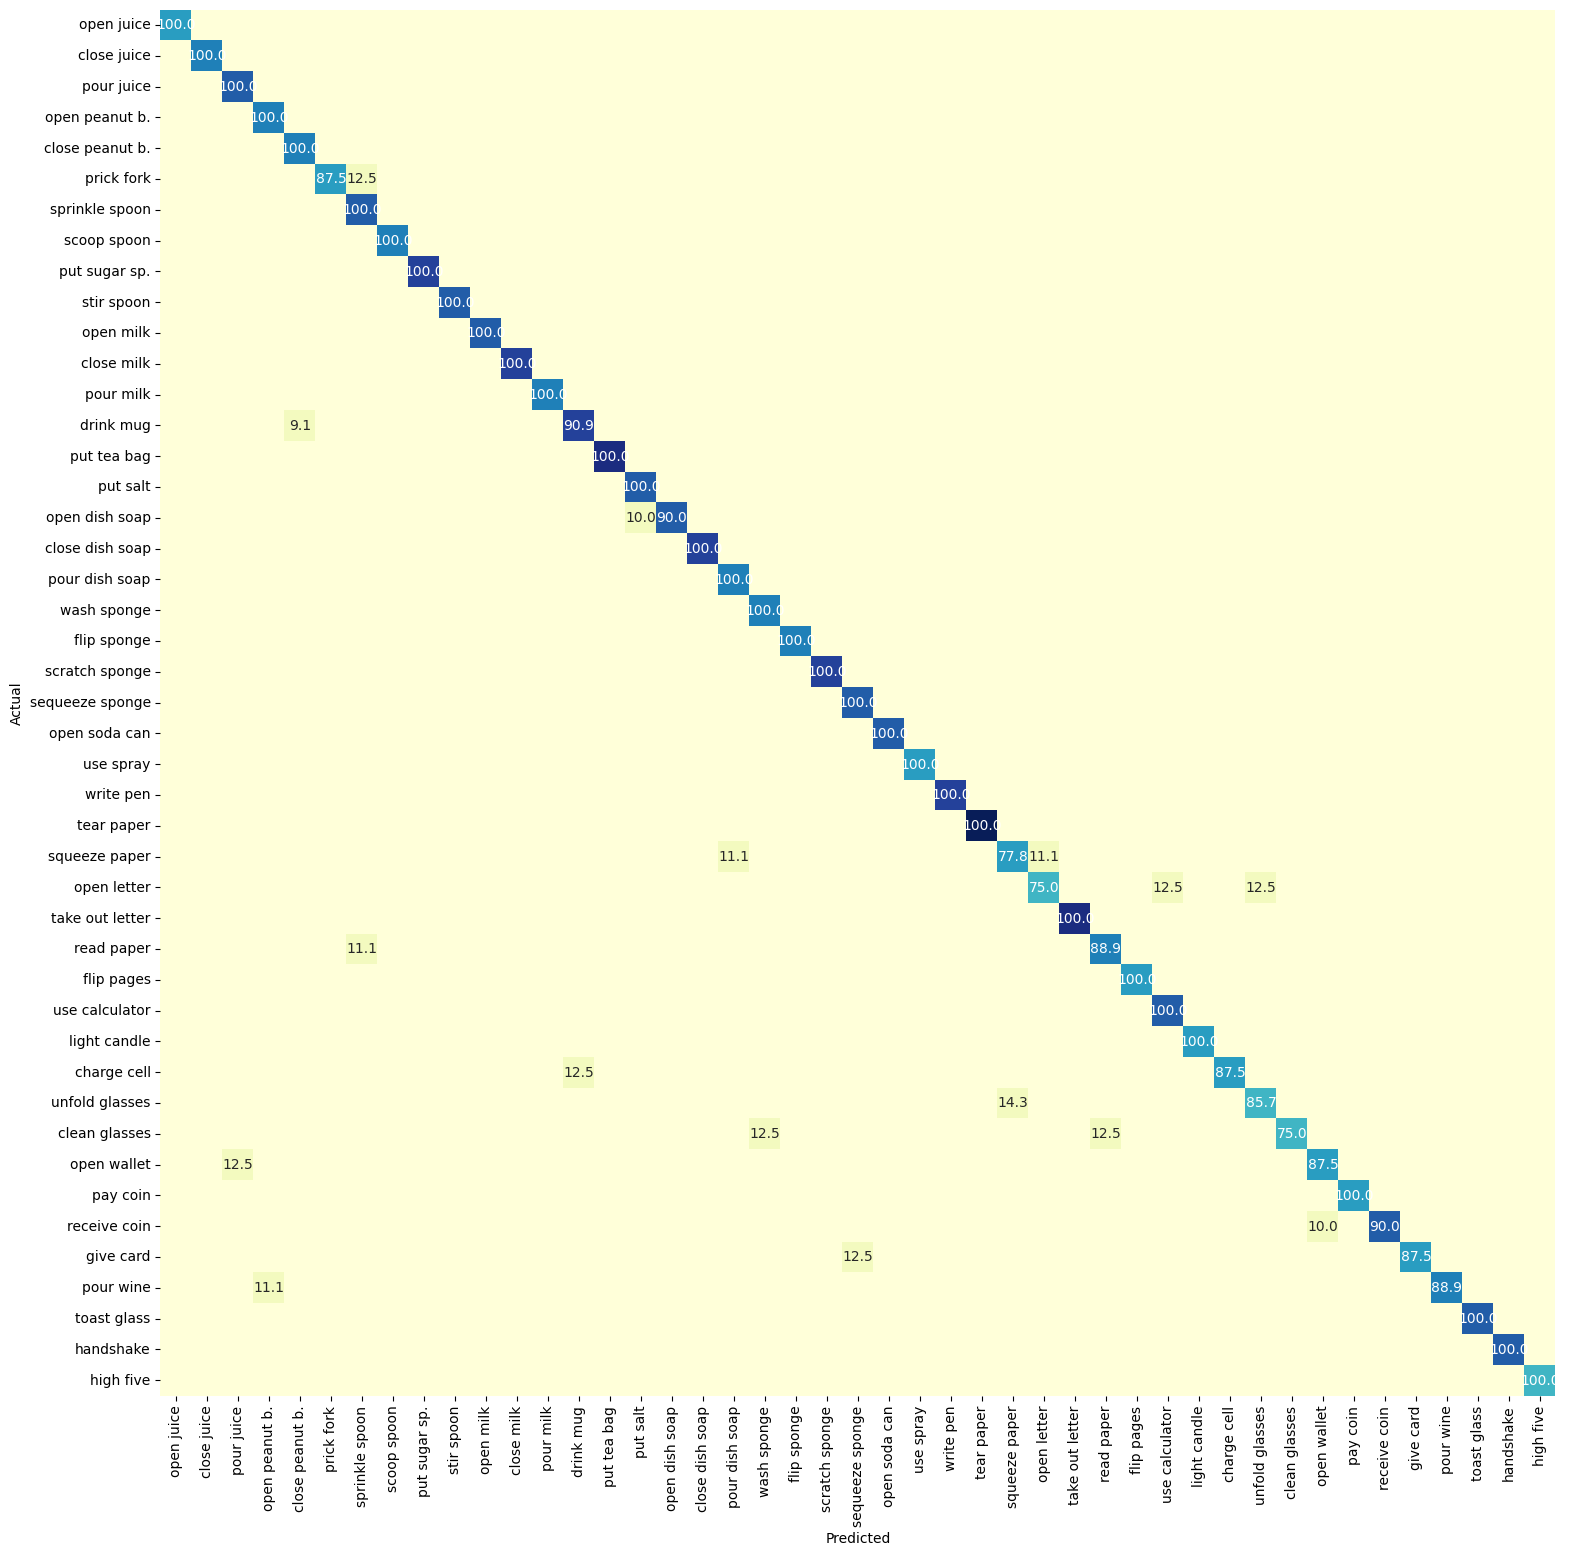

In [24]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test3.png', labels, ymap=None, figsize=(18,18))

# Policy gradient for frame selection  -------train

In [25]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

gamma = 0.7


class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(7680,3)) #32 8448  #7680
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):  
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r    
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class):
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 5 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = (np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1])) ## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 

    n_states=32 
    n_actions=3
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num =  1
    max_steps = 32  
#     numsteps = []
#     avg_numsteps = []
    all_rewards = []
#     x_trnew=[]
    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
#             x_tr_1=[]
            rng = default_rng()
            Action=[]
            if len(oridata[v])>=32:
#                 rng = default_rng()
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v] 
            original_fr=XX.clone().detach() 
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):              
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 20, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1)
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)


                M = get_CG(q,C)  
                q = q.reshape(1,32,20,3)
                M = M.reshape(1,32,190)

                original_fr = XX
        #             with torch.no_grad():
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1    
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)

        x_tr = torch.stack(x_tr)
        
        if episode==max_episode_num-1:
          final_ind.append(Action)
        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
Train = pickle.load(open(C.data_dir+"train_310.pkl","rb"))

oridata = []

for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,20,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    
labels = [int(Train['label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|██████████████████████████████████████| 783/783 [00:00<00:00, 30112.04it/s]


### epoch 1

In [27]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

 12%|█████                                     | 95/783 [01:08<08:12,  1.40it/s]


 25%|██████████                               | 192/783 [02:17<07:16,  1.35it/s]


 37%|███████████████▏                         | 289/783 [03:26<05:45,  1.43it/s]


 49%|████████████████████▏                    | 386/783 [04:35<04:48,  1.38it/s]


 62%|█████████████████████████▎               | 483/783 [05:43<03:32,  1.41it/s]


 74%|██████████████████████████████▎          | 580/783 [06:54<02:24,  1.41it/s]


 86%|███████████████████████████████████▍     | 677/783 [08:04<01:17,  1.36it/s]


 99%|████████████████████████████████████████▌| 774/783 [09:14<00:06,  1.36it/s]


100%|████████████████████████████████████████████| 1/1 [09:20<00:00, 560.65s/it]


[-11.40625]


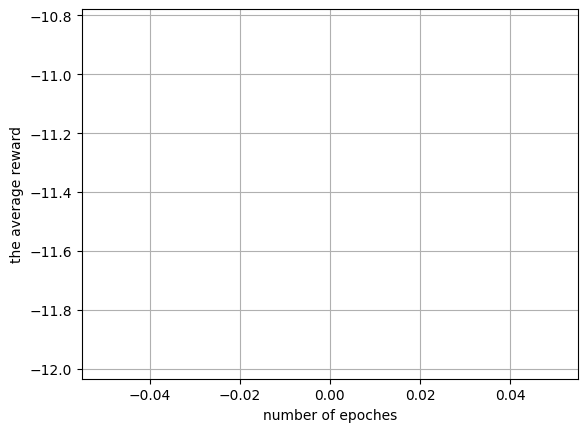

In [28]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_310_test4.png")
plt.grid()

In [29]:
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 783/783 [00:06<00:00, 129.64it/s]


In [30]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 783 samples, validate on 392 samples
Epoch 1/600
783/783 [==============================] - 4s 5ms/step - loss: 0.2068 - accuracy: 0.9642 - val_loss: 0.3386 - val_accuracy: 0.9133
Epoch 2/600
783/783 [==============================] - 0s 134us/step - loss: 0.2575 - accuracy: 0.9502 - val_loss: 0.4539 - val_accuracy: 0.8699
Epoch 3/600
783/783 [==============================] - 0s 113us/step - loss: 0.2125 - accuracy: 0.9693 - val_loss: 0.4838 - val_accuracy: 0.8673
Epoch 4/600
783/783 [==============================] - 0s 120us/step - loss: 0.2270 - accuracy: 0.9630 - val_loss: 0.4093 - val_accuracy: 0.8827
Epoch 5/600
783/783 [==============================] - 0s 111us/step - loss: 0.2179 - accuracy: 0.9642 - val_loss: 0.4831 - val_accuracy: 0.8546
Epoch 6/600
783/783 [==============================] - 0s 111us/step - loss: 0.2415 - accuracy: 0.9553 - val_loss: 0.5641 - val_accuracy: 0.8418
Epoch 7/600
783/783 [==============================] - 0s 122us/step - loss: 0.2136 - 

Epoch 57/600
783/783 [==============================] - 0s 119us/step - loss: 0.0889 - accuracy: 0.9949 - val_loss: 0.3109 - val_accuracy: 0.9133
Epoch 58/600
783/783 [==============================] - 0s 127us/step - loss: 0.0780 - accuracy: 0.9949 - val_loss: 0.3101 - val_accuracy: 0.9133
Epoch 59/600
783/783 [==============================] - 0s 123us/step - loss: 0.0806 - accuracy: 0.9962 - val_loss: 0.3103 - val_accuracy: 0.9184
Epoch 60/600
783/783 [==============================] - 0s 126us/step - loss: 0.0847 - accuracy: 0.9936 - val_loss: 0.3108 - val_accuracy: 0.9209
Epoch 61/600
783/783 [==============================] - 0s 120us/step - loss: 0.0754 - accuracy: 0.9974 - val_loss: 0.3089 - val_accuracy: 0.9235
Epoch 62/600
783/783 [==============================] - 0s 119us/step - loss: 0.0896 - accuracy: 0.9923 - val_loss: 0.3069 - val_accuracy: 0.9260
Epoch 63/600
783/783 [==============================] - 0s 118us/step - loss: 0.0851 - accuracy: 0.9923 - val_loss: 0.3041 -

783/783 [==============================] - 0s 124us/step - loss: 0.0837 - accuracy: 0.9911 - val_loss: 0.2023 - val_accuracy: 0.9490
Epoch 114/600
783/783 [==============================] - 0s 123us/step - loss: 0.0728 - accuracy: 0.9987 - val_loss: 0.2013 - val_accuracy: 0.9490
Epoch 115/600
783/783 [==============================] - 0s 125us/step - loss: 0.0881 - accuracy: 0.9911 - val_loss: 0.2004 - val_accuracy: 0.9490
Epoch 116/600
783/783 [==============================] - 0s 123us/step - loss: 0.0813 - accuracy: 0.9936 - val_loss: 0.1996 - val_accuracy: 0.9490
Epoch 117/600
783/783 [==============================] - 0s 123us/step - loss: 0.0676 - accuracy: 0.9974 - val_loss: 0.1988 - val_accuracy: 0.9490
Epoch 118/600
783/783 [==============================] - 0s 126us/step - loss: 0.0613 - accuracy: 0.9987 - val_loss: 0.1979 - val_accuracy: 0.9490
Epoch 119/600
783/783 [==============================] - 0s 117us/step - loss: 0.0949 - accuracy: 0.9911 - val_loss: 0.1969 - val_ac

Epoch 169/600
783/783 [==============================] - 0s 125us/step - loss: 0.0738 - accuracy: 0.9987 - val_loss: 0.1708 - val_accuracy: 0.9515
Epoch 170/600
783/783 [==============================] - 0s 127us/step - loss: 0.0709 - accuracy: 0.9962 - val_loss: 0.1705 - val_accuracy: 0.9515
Epoch 171/600
783/783 [==============================] - 0s 123us/step - loss: 0.0772 - accuracy: 0.9949 - val_loss: 0.1702 - val_accuracy: 0.9515
Epoch 172/600
783/783 [==============================] - 0s 123us/step - loss: 0.0741 - accuracy: 0.9911 - val_loss: 0.1698 - val_accuracy: 0.9515
Epoch 173/600
783/783 [==============================] - 0s 123us/step - loss: 0.0678 - accuracy: 0.9987 - val_loss: 0.1695 - val_accuracy: 0.9515
Epoch 174/600
783/783 [==============================] - 0s 125us/step - loss: 0.0650 - accuracy: 0.9949 - val_loss: 0.1692 - val_accuracy: 0.9515
Epoch 175/600
783/783 [==============================] - 0s 123us/step - loss: 0.0776 - accuracy: 0.9974 - val_loss: 0

Epoch 225/600
783/783 [==============================] - 0s 120us/step - loss: 0.0726 - accuracy: 0.9962 - val_loss: 0.1560 - val_accuracy: 0.9566
Epoch 226/600
783/783 [==============================] - 0s 124us/step - loss: 0.0742 - accuracy: 0.9974 - val_loss: 0.1559 - val_accuracy: 0.9566
Epoch 227/600
783/783 [==============================] - 0s 120us/step - loss: 0.0891 - accuracy: 0.9911 - val_loss: 0.1557 - val_accuracy: 0.9566
Epoch 228/600
783/783 [==============================] - 0s 123us/step - loss: 0.0716 - accuracy: 0.9962 - val_loss: 0.1556 - val_accuracy: 0.9566
Epoch 229/600
783/783 [==============================] - 0s 131us/step - loss: 0.0730 - accuracy: 0.9923 - val_loss: 0.1554 - val_accuracy: 0.9566
Epoch 230/600
783/783 [==============================] - 0s 129us/step - loss: 0.0674 - accuracy: 0.9936 - val_loss: 0.1552 - val_accuracy: 0.9566
Epoch 231/600
783/783 [==============================] - 0s 123us/step - loss: 0.0795 - accuracy: 0.9911 - val_loss: 0

Epoch 281/600
783/783 [==============================] - 0s 121us/step - loss: 0.0773 - accuracy: 0.9936 - val_loss: 0.1489 - val_accuracy: 0.9617
Epoch 282/600
783/783 [==============================] - 0s 121us/step - loss: 0.0670 - accuracy: 0.9974 - val_loss: 0.1489 - val_accuracy: 0.9617
Epoch 283/600
783/783 [==============================] - 0s 121us/step - loss: 0.0687 - accuracy: 0.9949 - val_loss: 0.1489 - val_accuracy: 0.9617
Epoch 284/600
783/783 [==============================] - 0s 128us/step - loss: 0.0720 - accuracy: 0.9974 - val_loss: 0.1488 - val_accuracy: 0.9617
Epoch 285/600
783/783 [==============================] - 0s 123us/step - loss: 0.0717 - accuracy: 0.9974 - val_loss: 0.1487 - val_accuracy: 0.9617
Epoch 286/600
783/783 [==============================] - 0s 128us/step - loss: 0.0817 - accuracy: 0.9911 - val_loss: 0.1487 - val_accuracy: 0.9617
Epoch 287/600
783/783 [==============================] - 0s 124us/step - loss: 0.0706 - accuracy: 0.9949 - val_loss: 0

Epoch 337/600
783/783 [==============================] - 0s 138us/step - loss: 0.0713 - accuracy: 0.9962 - val_loss: 0.1468 - val_accuracy: 0.9617
Epoch 338/600
783/783 [==============================] - 0s 145us/step - loss: 0.0714 - accuracy: 0.9949 - val_loss: 0.1469 - val_accuracy: 0.9617
Epoch 339/600
783/783 [==============================] - 0s 125us/step - loss: 0.0752 - accuracy: 0.9936 - val_loss: 0.1468 - val_accuracy: 0.9617
Epoch 340/600
783/783 [==============================] - 0s 123us/step - loss: 0.0622 - accuracy: 0.9974 - val_loss: 0.1468 - val_accuracy: 0.9617
Epoch 341/600
783/783 [==============================] - 0s 119us/step - loss: 0.0738 - accuracy: 0.9923 - val_loss: 0.1468 - val_accuracy: 0.9617
Epoch 342/600
783/783 [==============================] - 0s 127us/step - loss: 0.0683 - accuracy: 0.9974 - val_loss: 0.1468 - val_accuracy: 0.9617
Epoch 343/600
783/783 [==============================] - 0s 119us/step - loss: 0.0669 - accuracy: 0.9974 - val_loss: 0

Epoch 393/600
783/783 [==============================] - 0s 122us/step - loss: 0.0763 - accuracy: 0.9987 - val_loss: 0.1459 - val_accuracy: 0.9617
Epoch 394/600
783/783 [==============================] - 0s 127us/step - loss: 0.0826 - accuracy: 0.9949 - val_loss: 0.1459 - val_accuracy: 0.9617
Epoch 395/600
783/783 [==============================] - 0s 121us/step - loss: 0.0632 - accuracy: 0.9923 - val_loss: 0.1459 - val_accuracy: 0.9617
Epoch 396/600
783/783 [==============================] - 0s 119us/step - loss: 0.0676 - accuracy: 0.9962 - val_loss: 0.1460 - val_accuracy: 0.9617
Epoch 397/600
783/783 [==============================] - 0s 118us/step - loss: 0.0683 - accuracy: 0.9987 - val_loss: 0.1460 - val_accuracy: 0.9617
Epoch 398/600
783/783 [==============================] - 0s 121us/step - loss: 0.0759 - accuracy: 0.9911 - val_loss: 0.1460 - val_accuracy: 0.9617
Epoch 399/600
783/783 [==============================] - 0s 121us/step - loss: 0.0635 - accuracy: 0.9987 - val_loss: 0

Epoch 449/600
783/783 [==============================] - 0s 121us/step - loss: 0.0765 - accuracy: 0.9949 - val_loss: 0.1458 - val_accuracy: 0.9617
Epoch 450/600
783/783 [==============================] - 0s 118us/step - loss: 0.0708 - accuracy: 0.9962 - val_loss: 0.1458 - val_accuracy: 0.9617
Epoch 451/600
783/783 [==============================] - 0s 124us/step - loss: 0.0743 - accuracy: 0.9974 - val_loss: 0.1458 - val_accuracy: 0.9617
Epoch 452/600
783/783 [==============================] - 0s 119us/step - loss: 0.0772 - accuracy: 0.9936 - val_loss: 0.1459 - val_accuracy: 0.9617
Epoch 453/600
783/783 [==============================] - 0s 127us/step - loss: 0.0623 - accuracy: 0.9974 - val_loss: 0.1459 - val_accuracy: 0.9617
Epoch 454/600
783/783 [==============================] - 0s 120us/step - loss: 0.0813 - accuracy: 0.9923 - val_loss: 0.1459 - val_accuracy: 0.9617
Epoch 455/600
783/783 [==============================] - 0s 120us/step - loss: 0.0597 - accuracy: 0.9962 - val_loss: 0

Epoch 505/600
783/783 [==============================] - 0s 122us/step - loss: 0.0797 - accuracy: 0.9962 - val_loss: 0.1440 - val_accuracy: 0.9592
Epoch 506/600
783/783 [==============================] - 0s 119us/step - loss: 0.0659 - accuracy: 0.9974 - val_loss: 0.1440 - val_accuracy: 0.9592
Epoch 507/600
783/783 [==============================] - 0s 120us/step - loss: 0.0674 - accuracy: 0.9949 - val_loss: 0.1439 - val_accuracy: 0.9592
Epoch 508/600
783/783 [==============================] - 0s 122us/step - loss: 0.0677 - accuracy: 0.9962 - val_loss: 0.1439 - val_accuracy: 0.9592
Epoch 509/600
783/783 [==============================] - 0s 120us/step - loss: 0.0625 - accuracy: 0.9962 - val_loss: 0.1439 - val_accuracy: 0.9592
Epoch 510/600
783/783 [==============================] - 0s 119us/step - loss: 0.0760 - accuracy: 0.9962 - val_loss: 0.1439 - val_accuracy: 0.9592
Epoch 511/600
783/783 [==============================] - 0s 118us/step - loss: 0.0689 - accuracy: 0.9987 - val_loss: 0

Epoch 561/600
783/783 [==============================] - 0s 117us/step - loss: 0.0671 - accuracy: 0.9962 - val_loss: 0.1415 - val_accuracy: 0.9643
Epoch 562/600
783/783 [==============================] - 0s 120us/step - loss: 0.0695 - accuracy: 0.9962 - val_loss: 0.1414 - val_accuracy: 0.9643
Epoch 563/600
783/783 [==============================] - 0s 122us/step - loss: 0.0681 - accuracy: 0.9936 - val_loss: 0.1414 - val_accuracy: 0.9643
Epoch 564/600
783/783 [==============================] - 0s 118us/step - loss: 0.0721 - accuracy: 0.9949 - val_loss: 0.1413 - val_accuracy: 0.9643
Epoch 565/600
783/783 [==============================] - 0s 120us/step - loss: 0.0632 - accuracy: 0.9949 - val_loss: 0.1413 - val_accuracy: 0.9643
Epoch 566/600
783/783 [==============================] - 0s 123us/step - loss: 0.0674 - accuracy: 0.9962 - val_loss: 0.1413 - val_accuracy: 0.9643
Epoch 567/600
783/783 [==============================] - 0s 119us/step - loss: 0.0746 - accuracy: 0.9923 - val_loss: 0

In [31]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [32]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [33]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9617346938775511


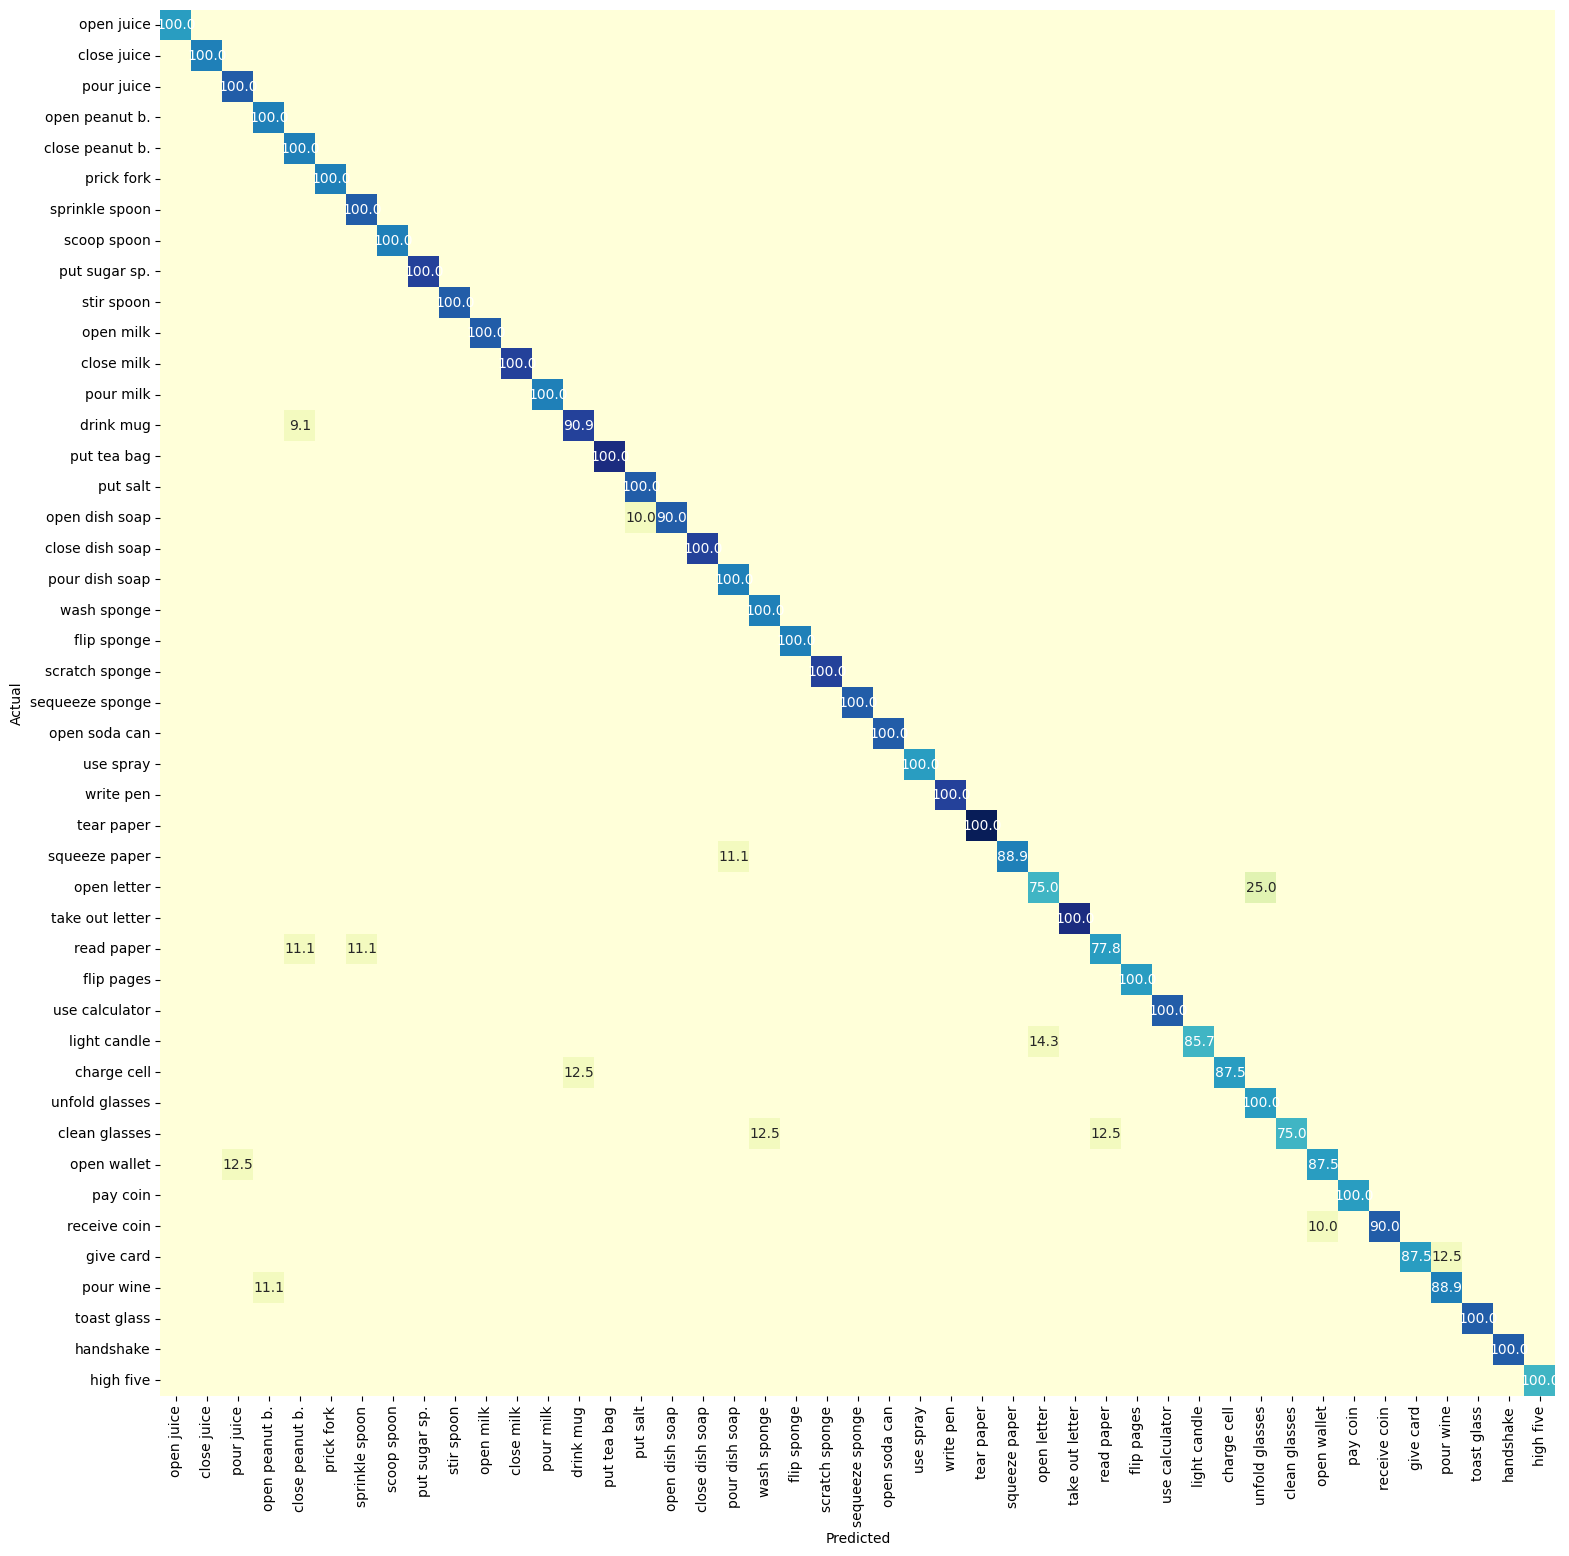

In [34]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test5.png', labels, ymap=None, figsize=(18,18))

### epoch 2 

In [35]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

 12%|█████                                     | 95/783 [01:07<08:32,  1.34it/s]


 25%|██████████                               | 192/783 [02:19<07:22,  1.34it/s]


 37%|███████████████▏                         | 289/783 [03:28<05:52,  1.40it/s]


 49%|████████████████████▏                    | 386/783 [04:37<04:40,  1.42it/s]


 62%|█████████████████████████▎               | 483/783 [05:47<03:26,  1.45it/s]


 74%|██████████████████████████████▎          | 580/783 [06:58<02:23,  1.42it/s]


 86%|███████████████████████████████████▍     | 677/783 [08:07<01:15,  1.40it/s]


 99%|████████████████████████████████████████▌| 774/783 [09:17<00:06,  1.40it/s]


100%|████████████████████████████████████████████| 1/1 [09:23<00:00, 563.78s/it]


In [36]:
print(all_rewards)
#plt.plot(all_rewards)
#plt.xlabel('number of epoches')
#plt.ylabel('the average reward')
#plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_310_test2.png")
#plt.grid()

[-24.46875]


In [37]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 783/783 [00:05<00:00, 138.67it/s]


In [38]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 783 samples, validate on 392 samples
Epoch 1/600
783/783 [==============================] - 4s 5ms/step - loss: 0.0706 - accuracy: 0.9962 - val_loss: 0.1755 - val_accuracy: 0.9490
Epoch 2/600
783/783 [==============================] - 0s 137us/step - loss: 0.0954 - accuracy: 0.9860 - val_loss: 0.2194 - val_accuracy: 0.9490
Epoch 3/600
783/783 [==============================] - 0s 112us/step - loss: 0.1191 - accuracy: 0.9808 - val_loss: 0.3197 - val_accuracy: 0.9107
Epoch 4/600
783/783 [==============================] - 0s 147us/step - loss: 0.0998 - accuracy: 0.9911 - val_loss: 0.2885 - val_accuracy: 0.9158
Epoch 5/600
783/783 [==============================] - 0s 123us/step - loss: 0.1044 - accuracy: 0.9872 - val_loss: 0.2904 - val_accuracy: 0.9184
Epoch 6/600
783/783 [==============================] - 0s 145us/step - loss: 0.1117 - accuracy: 0.9860 - val_loss: 0.2998 - val_accuracy: 0.9133
Epoch 7/600
783/783 [==============================] - 0s 120us/step - loss: 0.1229 - 

Epoch 57/600
783/783 [==============================] - 0s 122us/step - loss: 0.0525 - accuracy: 1.0000 - val_loss: 0.1681 - val_accuracy: 0.9490
Epoch 58/600
783/783 [==============================] - 0s 153us/step - loss: 0.0559 - accuracy: 0.9974 - val_loss: 0.1676 - val_accuracy: 0.9464
Epoch 59/600
783/783 [==============================] - 0s 124us/step - loss: 0.0638 - accuracy: 0.9974 - val_loss: 0.1672 - val_accuracy: 0.9464
Epoch 60/600
783/783 [==============================] - 0s 152us/step - loss: 0.0520 - accuracy: 0.9987 - val_loss: 0.1668 - val_accuracy: 0.9464
Epoch 61/600
783/783 [==============================] - 0s 125us/step - loss: 0.0638 - accuracy: 0.9936 - val_loss: 0.1663 - val_accuracy: 0.9464
Epoch 62/600
783/783 [==============================] - 0s 161us/step - loss: 0.0590 - accuracy: 0.9974 - val_loss: 0.1657 - val_accuracy: 0.9515
Epoch 63/600
783/783 [==============================] - 0s 134us/step - loss: 0.0614 - accuracy: 0.9936 - val_loss: 0.1652 -

783/783 [==============================] - 0s 122us/step - loss: 0.0545 - accuracy: 0.9949 - val_loss: 0.1500 - val_accuracy: 0.9592
Epoch 114/600
783/783 [==============================] - 0s 150us/step - loss: 0.0494 - accuracy: 0.9987 - val_loss: 0.1499 - val_accuracy: 0.9592
Epoch 115/600
783/783 [==============================] - 0s 121us/step - loss: 0.0583 - accuracy: 0.9923 - val_loss: 0.1497 - val_accuracy: 0.9592
Epoch 116/600
783/783 [==============================] - 0s 149us/step - loss: 0.0467 - accuracy: 0.9974 - val_loss: 0.1495 - val_accuracy: 0.9592
Epoch 117/600
783/783 [==============================] - 0s 121us/step - loss: 0.0548 - accuracy: 0.9974 - val_loss: 0.1493 - val_accuracy: 0.9592
Epoch 118/600
783/783 [==============================] - 0s 146us/step - loss: 0.0517 - accuracy: 0.9936 - val_loss: 0.1492 - val_accuracy: 0.9592
Epoch 119/600
783/783 [==============================] - 0s 125us/step - loss: 0.0454 - accuracy: 0.9974 - val_loss: 0.1490 - val_ac

Epoch 169/600
783/783 [==============================] - 0s 127us/step - loss: 0.0575 - accuracy: 0.9962 - val_loss: 0.1442 - val_accuracy: 0.9643
Epoch 170/600
783/783 [==============================] - 0s 156us/step - loss: 0.0467 - accuracy: 0.9974 - val_loss: 0.1441 - val_accuracy: 0.9643
Epoch 171/600
783/783 [==============================] - 0s 125us/step - loss: 0.0554 - accuracy: 0.9949 - val_loss: 0.1440 - val_accuracy: 0.9643
Epoch 172/600
783/783 [==============================] - 0s 158us/step - loss: 0.0650 - accuracy: 0.9923 - val_loss: 0.1438 - val_accuracy: 0.9643
Epoch 173/600
783/783 [==============================] - 0s 125us/step - loss: 0.0556 - accuracy: 0.9949 - val_loss: 0.1437 - val_accuracy: 0.9643
Epoch 174/600
783/783 [==============================] - 0s 154us/step - loss: 0.0508 - accuracy: 0.9987 - val_loss: 0.1436 - val_accuracy: 0.9643
Epoch 175/600
783/783 [==============================] - 0s 127us/step - loss: 0.0516 - accuracy: 0.9974 - val_loss: 0

Epoch 225/600
783/783 [==============================] - 0s 126us/step - loss: 0.0551 - accuracy: 0.9962 - val_loss: 0.1412 - val_accuracy: 0.9617
Epoch 226/600
783/783 [==============================] - 0s 164us/step - loss: 0.0669 - accuracy: 0.9949 - val_loss: 0.1411 - val_accuracy: 0.9617
Epoch 227/600
783/783 [==============================] - 0s 125us/step - loss: 0.0548 - accuracy: 0.9949 - val_loss: 0.1411 - val_accuracy: 0.9617
Epoch 228/600
783/783 [==============================] - 0s 156us/step - loss: 0.0551 - accuracy: 0.9962 - val_loss: 0.1410 - val_accuracy: 0.9617
Epoch 229/600
783/783 [==============================] - 0s 124us/step - loss: 0.0496 - accuracy: 0.9974 - val_loss: 0.1410 - val_accuracy: 0.9617
Epoch 230/600
783/783 [==============================] - 0s 153us/step - loss: 0.0535 - accuracy: 0.9987 - val_loss: 0.1410 - val_accuracy: 0.9617
Epoch 231/600
783/783 [==============================] - 0s 118us/step - loss: 0.0484 - accuracy: 0.9974 - val_loss: 0

Epoch 281/600
783/783 [==============================] - 0s 125us/step - loss: 0.0529 - accuracy: 0.9962 - val_loss: 0.1405 - val_accuracy: 0.9643
Epoch 282/600
783/783 [==============================] - 0s 154us/step - loss: 0.0535 - accuracy: 0.9962 - val_loss: 0.1405 - val_accuracy: 0.9643
Epoch 283/600
783/783 [==============================] - 0s 124us/step - loss: 0.0484 - accuracy: 0.9949 - val_loss: 0.1406 - val_accuracy: 0.9643
Epoch 284/600
783/783 [==============================] - 0s 151us/step - loss: 0.0605 - accuracy: 0.9962 - val_loss: 0.1406 - val_accuracy: 0.9643
Epoch 285/600
783/783 [==============================] - 0s 126us/step - loss: 0.0504 - accuracy: 0.9987 - val_loss: 0.1406 - val_accuracy: 0.9643
Epoch 286/600
783/783 [==============================] - 0s 153us/step - loss: 0.0487 - accuracy: 0.9962 - val_loss: 0.1406 - val_accuracy: 0.9643
Epoch 287/600
783/783 [==============================] - 0s 119us/step - loss: 0.0469 - accuracy: 0.9987 - val_loss: 0

Epoch 337/600
783/783 [==============================] - 0s 119us/step - loss: 0.0493 - accuracy: 0.9949 - val_loss: 0.1412 - val_accuracy: 0.9617
Epoch 338/600
783/783 [==============================] - 0s 155us/step - loss: 0.0596 - accuracy: 0.9974 - val_loss: 0.1411 - val_accuracy: 0.9617
Epoch 339/600
783/783 [==============================] - 0s 118us/step - loss: 0.0608 - accuracy: 0.9949 - val_loss: 0.1410 - val_accuracy: 0.9617
Epoch 340/600
783/783 [==============================] - 0s 149us/step - loss: 0.0557 - accuracy: 0.9974 - val_loss: 0.1410 - val_accuracy: 0.9617
Epoch 341/600
783/783 [==============================] - 0s 122us/step - loss: 0.0468 - accuracy: 0.9936 - val_loss: 0.1409 - val_accuracy: 0.9617
Epoch 342/600
783/783 [==============================] - 0s 156us/step - loss: 0.0491 - accuracy: 0.9987 - val_loss: 0.1408 - val_accuracy: 0.9617
Epoch 343/600
783/783 [==============================] - 0s 125us/step - loss: 0.0516 - accuracy: 0.9962 - val_loss: 0

Epoch 393/600
783/783 [==============================] - 0s 128us/step - loss: 0.0434 - accuracy: 1.0000 - val_loss: 0.1408 - val_accuracy: 0.9592
Epoch 394/600
783/783 [==============================] - 0s 152us/step - loss: 0.0526 - accuracy: 0.9962 - val_loss: 0.1407 - val_accuracy: 0.9592
Epoch 395/600
783/783 [==============================] - 0s 127us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.1407 - val_accuracy: 0.9592
Epoch 396/600
783/783 [==============================] - 0s 150us/step - loss: 0.0461 - accuracy: 0.9974 - val_loss: 0.1406 - val_accuracy: 0.9592
Epoch 397/600
783/783 [==============================] - 0s 125us/step - loss: 0.0409 - accuracy: 0.9974 - val_loss: 0.1407 - val_accuracy: 0.9592
Epoch 398/600
783/783 [==============================] - 0s 157us/step - loss: 0.0593 - accuracy: 0.9898 - val_loss: 0.1408 - val_accuracy: 0.9592
Epoch 399/600
783/783 [==============================] - 0s 123us/step - loss: 0.0598 - accuracy: 0.9974 - val_loss: 0

Epoch 449/600
783/783 [==============================] - 0s 121us/step - loss: 0.0495 - accuracy: 0.9949 - val_loss: 0.1414 - val_accuracy: 0.9617
Epoch 450/600
783/783 [==============================] - 0s 152us/step - loss: 0.0476 - accuracy: 0.9987 - val_loss: 0.1414 - val_accuracy: 0.9617
Epoch 451/600
783/783 [==============================] - 0s 119us/step - loss: 0.0548 - accuracy: 0.9949 - val_loss: 0.1414 - val_accuracy: 0.9617
Epoch 452/600
783/783 [==============================] - 0s 155us/step - loss: 0.0602 - accuracy: 0.9974 - val_loss: 0.1413 - val_accuracy: 0.9617
Epoch 453/600
783/783 [==============================] - 0s 125us/step - loss: 0.0532 - accuracy: 0.9962 - val_loss: 0.1414 - val_accuracy: 0.9617
Epoch 454/600
783/783 [==============================] - 0s 160us/step - loss: 0.0460 - accuracy: 0.9974 - val_loss: 0.1414 - val_accuracy: 0.9617
Epoch 455/600
783/783 [==============================] - 0s 122us/step - loss: 0.0512 - accuracy: 0.9962 - val_loss: 0

Epoch 505/600
783/783 [==============================] - 0s 123us/step - loss: 0.0499 - accuracy: 1.0000 - val_loss: 0.1394 - val_accuracy: 0.9617
Epoch 506/600
783/783 [==============================] - 0s 150us/step - loss: 0.0511 - accuracy: 0.9987 - val_loss: 0.1395 - val_accuracy: 0.9617
Epoch 507/600
783/783 [==============================] - 0s 119us/step - loss: 0.0516 - accuracy: 0.9974 - val_loss: 0.1394 - val_accuracy: 0.9617
Epoch 508/600
783/783 [==============================] - 0s 151us/step - loss: 0.0563 - accuracy: 0.9911 - val_loss: 0.1394 - val_accuracy: 0.9617
Epoch 509/600
783/783 [==============================] - 0s 121us/step - loss: 0.0386 - accuracy: 1.0000 - val_loss: 0.1394 - val_accuracy: 0.9617
Epoch 510/600
783/783 [==============================] - 0s 150us/step - loss: 0.0577 - accuracy: 0.9987 - val_loss: 0.1394 - val_accuracy: 0.9617
Epoch 511/600
783/783 [==============================] - 0s 125us/step - loss: 0.0466 - accuracy: 0.9987 - val_loss: 0

Epoch 561/600
783/783 [==============================] - 0s 133us/step - loss: 0.0482 - accuracy: 1.0000 - val_loss: 0.1370 - val_accuracy: 0.9668
Epoch 562/600
783/783 [==============================] - 0s 158us/step - loss: 0.0580 - accuracy: 0.9936 - val_loss: 0.1370 - val_accuracy: 0.9668
Epoch 563/600
783/783 [==============================] - 0s 130us/step - loss: 0.0503 - accuracy: 0.9949 - val_loss: 0.1371 - val_accuracy: 0.9668
Epoch 564/600
783/783 [==============================] - 0s 154us/step - loss: 0.0433 - accuracy: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9668
Epoch 565/600
783/783 [==============================] - 0s 122us/step - loss: 0.0459 - accuracy: 0.9974 - val_loss: 0.1372 - val_accuracy: 0.9668
Epoch 566/600
783/783 [==============================] - 0s 154us/step - loss: 0.0543 - accuracy: 0.9962 - val_loss: 0.1372 - val_accuracy: 0.9668
Epoch 567/600
783/783 [==============================] - 0s 136us/step - loss: 0.0470 - accuracy: 0.9987 - val_loss: 0

In [39]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9668367346938775


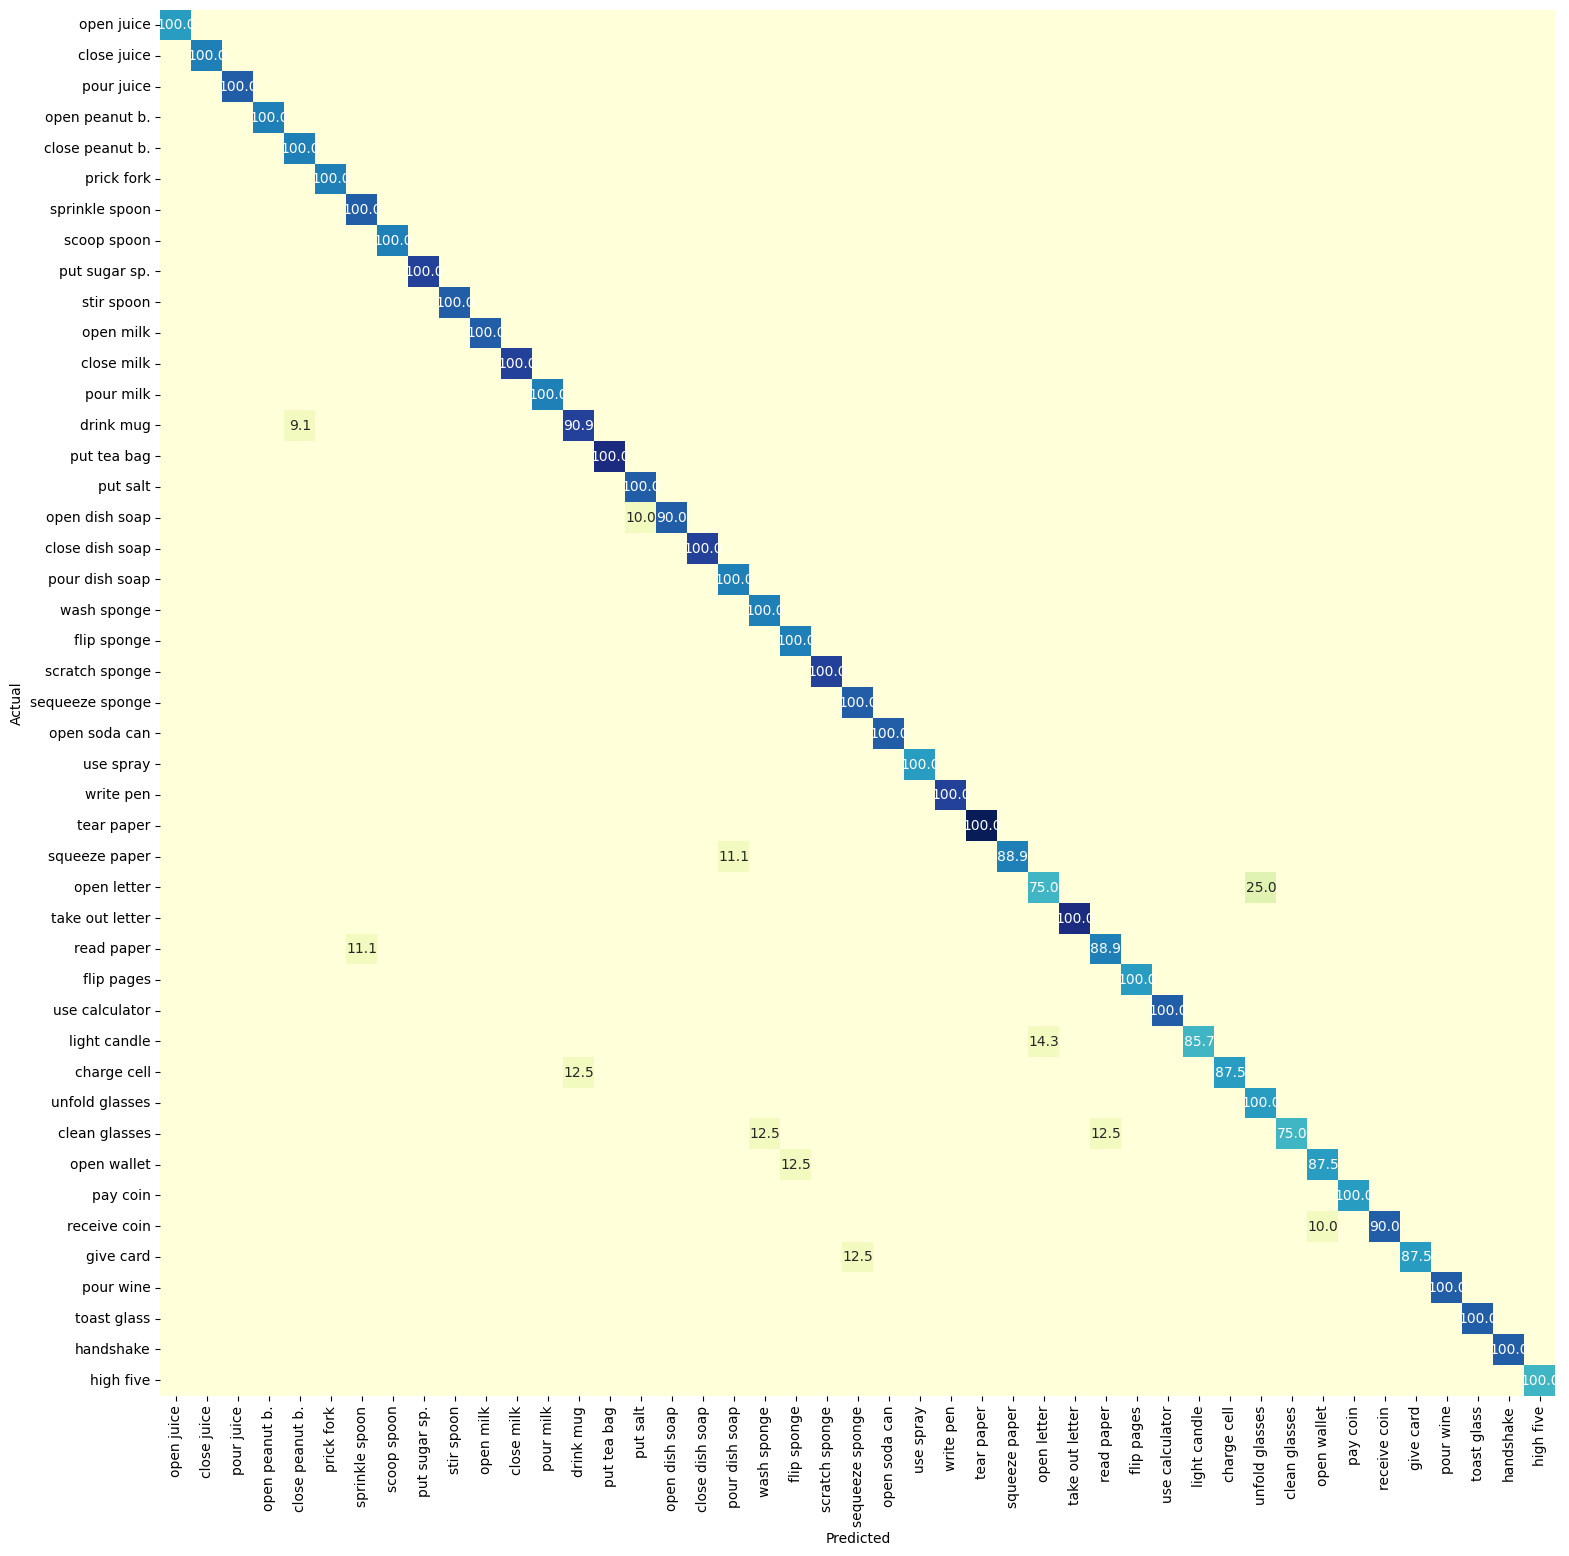

In [40]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test6.png', labels, ymap=None, figsize=(18,18))

### epoch 3 

In [41]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 12%|█████                                     | 95/783 [01:04<07:58,  1.44it/s]


 25%|██████████                               | 192/783 [02:11<06:49,  1.44it/s]


 37%|███████████████▏                         | 289/783 [03:18<05:41,  1.45it/s]


 49%|████████████████████▏                    | 386/783 [04:25<04:46,  1.38it/s]


 62%|█████████████████████████▎               | 483/783 [05:30<03:28,  1.44it/s]


 74%|██████████████████████████████▎          | 580/783 [06:39<02:21,  1.44it/s]


 86%|███████████████████████████████████▍     | 677/783 [07:47<01:11,  1.48it/s]


 99%|████████████████████████████████████████▌| 774/783 [08:52<00:06,  1.42it/s]


100%|████████████████████████████████████████████| 1/1 [08:58<00:00, 538.92s/it]


[-24.46875]


100%|████████████████████████████████████████| 783/783 [00:05<00:00, 131.53it/s]


In [42]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 783 samples, validate on 392 samples
Epoch 1/600
783/783 [==============================] - 4s 5ms/step - loss: 0.0538 - accuracy: 0.9974 - val_loss: 0.3437 - val_accuracy: 0.9107
Epoch 2/600
783/783 [==============================] - 0s 117us/step - loss: 0.0836 - accuracy: 0.9847 - val_loss: 0.3552 - val_accuracy: 0.8903
Epoch 3/600
783/783 [==============================] - 0s 115us/step - loss: 0.0793 - accuracy: 0.9923 - val_loss: 0.3272 - val_accuracy: 0.9056
Epoch 4/600
783/783 [==============================] - 0s 118us/step - loss: 0.0848 - accuracy: 0.9911 - val_loss: 0.2897 - val_accuracy: 0.9158
Epoch 5/600
783/783 [==============================] - 0s 118us/step - loss: 0.0796 - accuracy: 0.9898 - val_loss: 0.2908 - val_accuracy: 0.9082
Epoch 6/600
783/783 [==============================] - 0s 120us/step - loss: 0.0848 - accuracy: 0.9872 - val_loss: 0.3554 - val_accuracy: 0.9031
Epoch 7/600
783/783 [==============================] - 0s 126us/step - loss: 0.0827 - 

Epoch 57/600
783/783 [==============================] - 0s 128us/step - loss: 0.0524 - accuracy: 0.9974 - val_loss: 0.1454 - val_accuracy: 0.9617
Epoch 58/600
783/783 [==============================] - 0s 142us/step - loss: 0.0300 - accuracy: 0.9962 - val_loss: 0.1454 - val_accuracy: 0.9617
Epoch 59/600
783/783 [==============================] - 0s 130us/step - loss: 0.0405 - accuracy: 0.9962 - val_loss: 0.1453 - val_accuracy: 0.9617
Epoch 60/600
783/783 [==============================] - 0s 120us/step - loss: 0.0379 - accuracy: 0.9987 - val_loss: 0.1453 - val_accuracy: 0.9617
Epoch 61/600
783/783 [==============================] - 0s 120us/step - loss: 0.0419 - accuracy: 0.9987 - val_loss: 0.1452 - val_accuracy: 0.9617
Epoch 62/600
783/783 [==============================] - 0s 122us/step - loss: 0.0408 - accuracy: 0.9974 - val_loss: 0.1453 - val_accuracy: 0.9617
Epoch 63/600
783/783 [==============================] - 0s 125us/step - loss: 0.0361 - accuracy: 0.9974 - val_loss: 0.1455 -

783/783 [==============================] - 0s 126us/step - loss: 0.0470 - accuracy: 0.9987 - val_loss: 0.1410 - val_accuracy: 0.9592
Epoch 114/600
783/783 [==============================] - 0s 127us/step - loss: 0.0411 - accuracy: 0.9962 - val_loss: 0.1410 - val_accuracy: 0.9592
Epoch 115/600
783/783 [==============================] - 0s 135us/step - loss: 0.0331 - accuracy: 0.9974 - val_loss: 0.1410 - val_accuracy: 0.9592
Epoch 116/600
783/783 [==============================] - 0s 145us/step - loss: 0.0348 - accuracy: 0.9974 - val_loss: 0.1410 - val_accuracy: 0.9592
Epoch 117/600
783/783 [==============================] - 0s 139us/step - loss: 0.0341 - accuracy: 0.9987 - val_loss: 0.1410 - val_accuracy: 0.9592
Epoch 118/600
783/783 [==============================] - 0s 140us/step - loss: 0.0389 - accuracy: 0.9987 - val_loss: 0.1409 - val_accuracy: 0.9592
Epoch 119/600
783/783 [==============================] - 0s 143us/step - loss: 0.0398 - accuracy: 0.9974 - val_loss: 0.1408 - val_ac

Epoch 169/600
783/783 [==============================] - 0s 129us/step - loss: 0.0399 - accuracy: 1.0000 - val_loss: 0.1372 - val_accuracy: 0.9592
Epoch 170/600
783/783 [==============================] - 0s 128us/step - loss: 0.0453 - accuracy: 0.9962 - val_loss: 0.1373 - val_accuracy: 0.9592
Epoch 171/600
783/783 [==============================] - 0s 132us/step - loss: 0.0435 - accuracy: 0.9923 - val_loss: 0.1374 - val_accuracy: 0.9592
Epoch 172/600
783/783 [==============================] - 0s 131us/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.1374 - val_accuracy: 0.9592
Epoch 173/600
783/783 [==============================] - 0s 131us/step - loss: 0.0467 - accuracy: 0.9949 - val_loss: 0.1375 - val_accuracy: 0.9592
Epoch 174/600
783/783 [==============================] - 0s 130us/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.1375 - val_accuracy: 0.9592
Epoch 175/600
783/783 [==============================] - 0s 129us/step - loss: 0.0359 - accuracy: 0.9949 - val_loss: 0

Epoch 225/600
783/783 [==============================] - 0s 129us/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.1364 - val_accuracy: 0.9592
Epoch 226/600
783/783 [==============================] - 0s 127us/step - loss: 0.0328 - accuracy: 0.9987 - val_loss: 0.1364 - val_accuracy: 0.9592
Epoch 227/600
783/783 [==============================] - 0s 124us/step - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.1364 - val_accuracy: 0.9592
Epoch 228/600
783/783 [==============================] - 0s 131us/step - loss: 0.0369 - accuracy: 0.9987 - val_loss: 0.1365 - val_accuracy: 0.9592
Epoch 229/600
783/783 [==============================] - 0s 149us/step - loss: 0.0354 - accuracy: 0.9987 - val_loss: 0.1365 - val_accuracy: 0.9592
Epoch 230/600
783/783 [==============================] - 0s 126us/step - loss: 0.0406 - accuracy: 0.9974 - val_loss: 0.1365 - val_accuracy: 0.9592
Epoch 231/600
783/783 [==============================] - 0s 128us/step - loss: 0.0410 - accuracy: 0.9974 - val_loss: 0

Epoch 281/600
783/783 [==============================] - 0s 124us/step - loss: 0.0342 - accuracy: 0.9962 - val_loss: 0.1361 - val_accuracy: 0.9592
Epoch 282/600
783/783 [==============================] - 0s 126us/step - loss: 0.0365 - accuracy: 0.9974 - val_loss: 0.1360 - val_accuracy: 0.9592
Epoch 283/600
783/783 [==============================] - 0s 129us/step - loss: 0.0345 - accuracy: 0.9974 - val_loss: 0.1359 - val_accuracy: 0.9592
Epoch 284/600
783/783 [==============================] - 0s 130us/step - loss: 0.0502 - accuracy: 0.9987 - val_loss: 0.1359 - val_accuracy: 0.9592
Epoch 285/600
783/783 [==============================] - 0s 128us/step - loss: 0.0381 - accuracy: 0.9987 - val_loss: 0.1358 - val_accuracy: 0.9592
Epoch 286/600
783/783 [==============================] - 0s 128us/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.1357 - val_accuracy: 0.9592
Epoch 287/600
783/783 [==============================] - 0s 121us/step - loss: 0.0442 - accuracy: 0.9974 - val_loss: 0

Epoch 337/600
783/783 [==============================] - 0s 136us/step - loss: 0.0328 - accuracy: 0.9987 - val_loss: 0.1357 - val_accuracy: 0.9617
Epoch 338/600
783/783 [==============================] - 0s 131us/step - loss: 0.0404 - accuracy: 0.9949 - val_loss: 0.1357 - val_accuracy: 0.9617
Epoch 339/600
783/783 [==============================] - 0s 140us/step - loss: 0.0299 - accuracy: 0.9962 - val_loss: 0.1356 - val_accuracy: 0.9617
Epoch 340/600
783/783 [==============================] - 0s 135us/step - loss: 0.0350 - accuracy: 0.9987 - val_loss: 0.1355 - val_accuracy: 0.9617
Epoch 341/600
783/783 [==============================] - 0s 125us/step - loss: 0.0401 - accuracy: 0.9987 - val_loss: 0.1354 - val_accuracy: 0.9617
Epoch 342/600
783/783 [==============================] - 0s 125us/step - loss: 0.0343 - accuracy: 0.9987 - val_loss: 0.1354 - val_accuracy: 0.9617
Epoch 343/600
783/783 [==============================] - 0s 128us/step - loss: 0.0334 - accuracy: 0.9949 - val_loss: 0

Epoch 393/600
783/783 [==============================] - 0s 142us/step - loss: 0.0263 - accuracy: 0.9987 - val_loss: 0.1369 - val_accuracy: 0.9592
Epoch 394/600
783/783 [==============================] - 0s 134us/step - loss: 0.0330 - accuracy: 0.9987 - val_loss: 0.1369 - val_accuracy: 0.9592
Epoch 395/600
783/783 [==============================] - 0s 127us/step - loss: 0.0389 - accuracy: 0.9974 - val_loss: 0.1368 - val_accuracy: 0.9592
Epoch 396/600
783/783 [==============================] - 0s 137us/step - loss: 0.0383 - accuracy: 0.9962 - val_loss: 0.1368 - val_accuracy: 0.9592
Epoch 397/600
783/783 [==============================] - 0s 134us/step - loss: 0.0413 - accuracy: 0.9949 - val_loss: 0.1367 - val_accuracy: 0.9592
Epoch 398/600
783/783 [==============================] - 0s 122us/step - loss: 0.0356 - accuracy: 0.9962 - val_loss: 0.1366 - val_accuracy: 0.9592
Epoch 399/600
783/783 [==============================] - 0s 123us/step - loss: 0.0332 - accuracy: 0.9987 - val_loss: 0

Epoch 449/600
783/783 [==============================] - 0s 131us/step - loss: 0.0391 - accuracy: 0.9949 - val_loss: 0.1353 - val_accuracy: 0.9592
Epoch 450/600
783/783 [==============================] - 0s 135us/step - loss: 0.0344 - accuracy: 0.9987 - val_loss: 0.1352 - val_accuracy: 0.9592
Epoch 451/600
783/783 [==============================] - 0s 131us/step - loss: 0.0349 - accuracy: 1.0000 - val_loss: 0.1351 - val_accuracy: 0.9592
Epoch 452/600
783/783 [==============================] - 0s 150us/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.1351 - val_accuracy: 0.9592
Epoch 453/600
783/783 [==============================] - 0s 134us/step - loss: 0.0318 - accuracy: 0.9987 - val_loss: 0.1350 - val_accuracy: 0.9592
Epoch 454/600
783/783 [==============================] - 0s 126us/step - loss: 0.0391 - accuracy: 0.9974 - val_loss: 0.1349 - val_accuracy: 0.9592
Epoch 455/600
783/783 [==============================] - 0s 124us/step - loss: 0.0331 - accuracy: 0.9987 - val_loss: 0

Epoch 505/600
783/783 [==============================] - 0s 123us/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 0.1352 - val_accuracy: 0.9617
Epoch 506/600
783/783 [==============================] - 0s 127us/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 0.1352 - val_accuracy: 0.9617
Epoch 507/600
783/783 [==============================] - 0s 127us/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.1352 - val_accuracy: 0.9617
Epoch 508/600
783/783 [==============================] - 0s 129us/step - loss: 0.0388 - accuracy: 0.9974 - val_loss: 0.1353 - val_accuracy: 0.9617
Epoch 509/600
783/783 [==============================] - 0s 132us/step - loss: 0.0402 - accuracy: 0.9936 - val_loss: 0.1353 - val_accuracy: 0.9617
Epoch 510/600
783/783 [==============================] - 0s 128us/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.1354 - val_accuracy: 0.9617
Epoch 511/600
783/783 [==============================] - 0s 132us/step - loss: 0.0314 - accuracy: 0.9949 - val_loss: 0

Epoch 561/600
783/783 [==============================] - 0s 128us/step - loss: 0.0373 - accuracy: 0.9974 - val_loss: 0.1376 - val_accuracy: 0.9617
Epoch 562/600
783/783 [==============================] - 0s 127us/step - loss: 0.0321 - accuracy: 0.9987 - val_loss: 0.1376 - val_accuracy: 0.9617
Epoch 563/600
783/783 [==============================] - 0s 127us/step - loss: 0.0383 - accuracy: 0.9962 - val_loss: 0.1376 - val_accuracy: 0.9617
Epoch 564/600
783/783 [==============================] - 0s 129us/step - loss: 0.0293 - accuracy: 0.9987 - val_loss: 0.1376 - val_accuracy: 0.9617
Epoch 565/600
783/783 [==============================] - 0s 129us/step - loss: 0.0331 - accuracy: 0.9974 - val_loss: 0.1375 - val_accuracy: 0.9617
Epoch 566/600
783/783 [==============================] - 0s 132us/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.1375 - val_accuracy: 0.9617
Epoch 567/600
783/783 [==============================] - 0s 120us/step - loss: 0.0355 - accuracy: 0.9974 - val_loss: 0

In [43]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9617346938775511


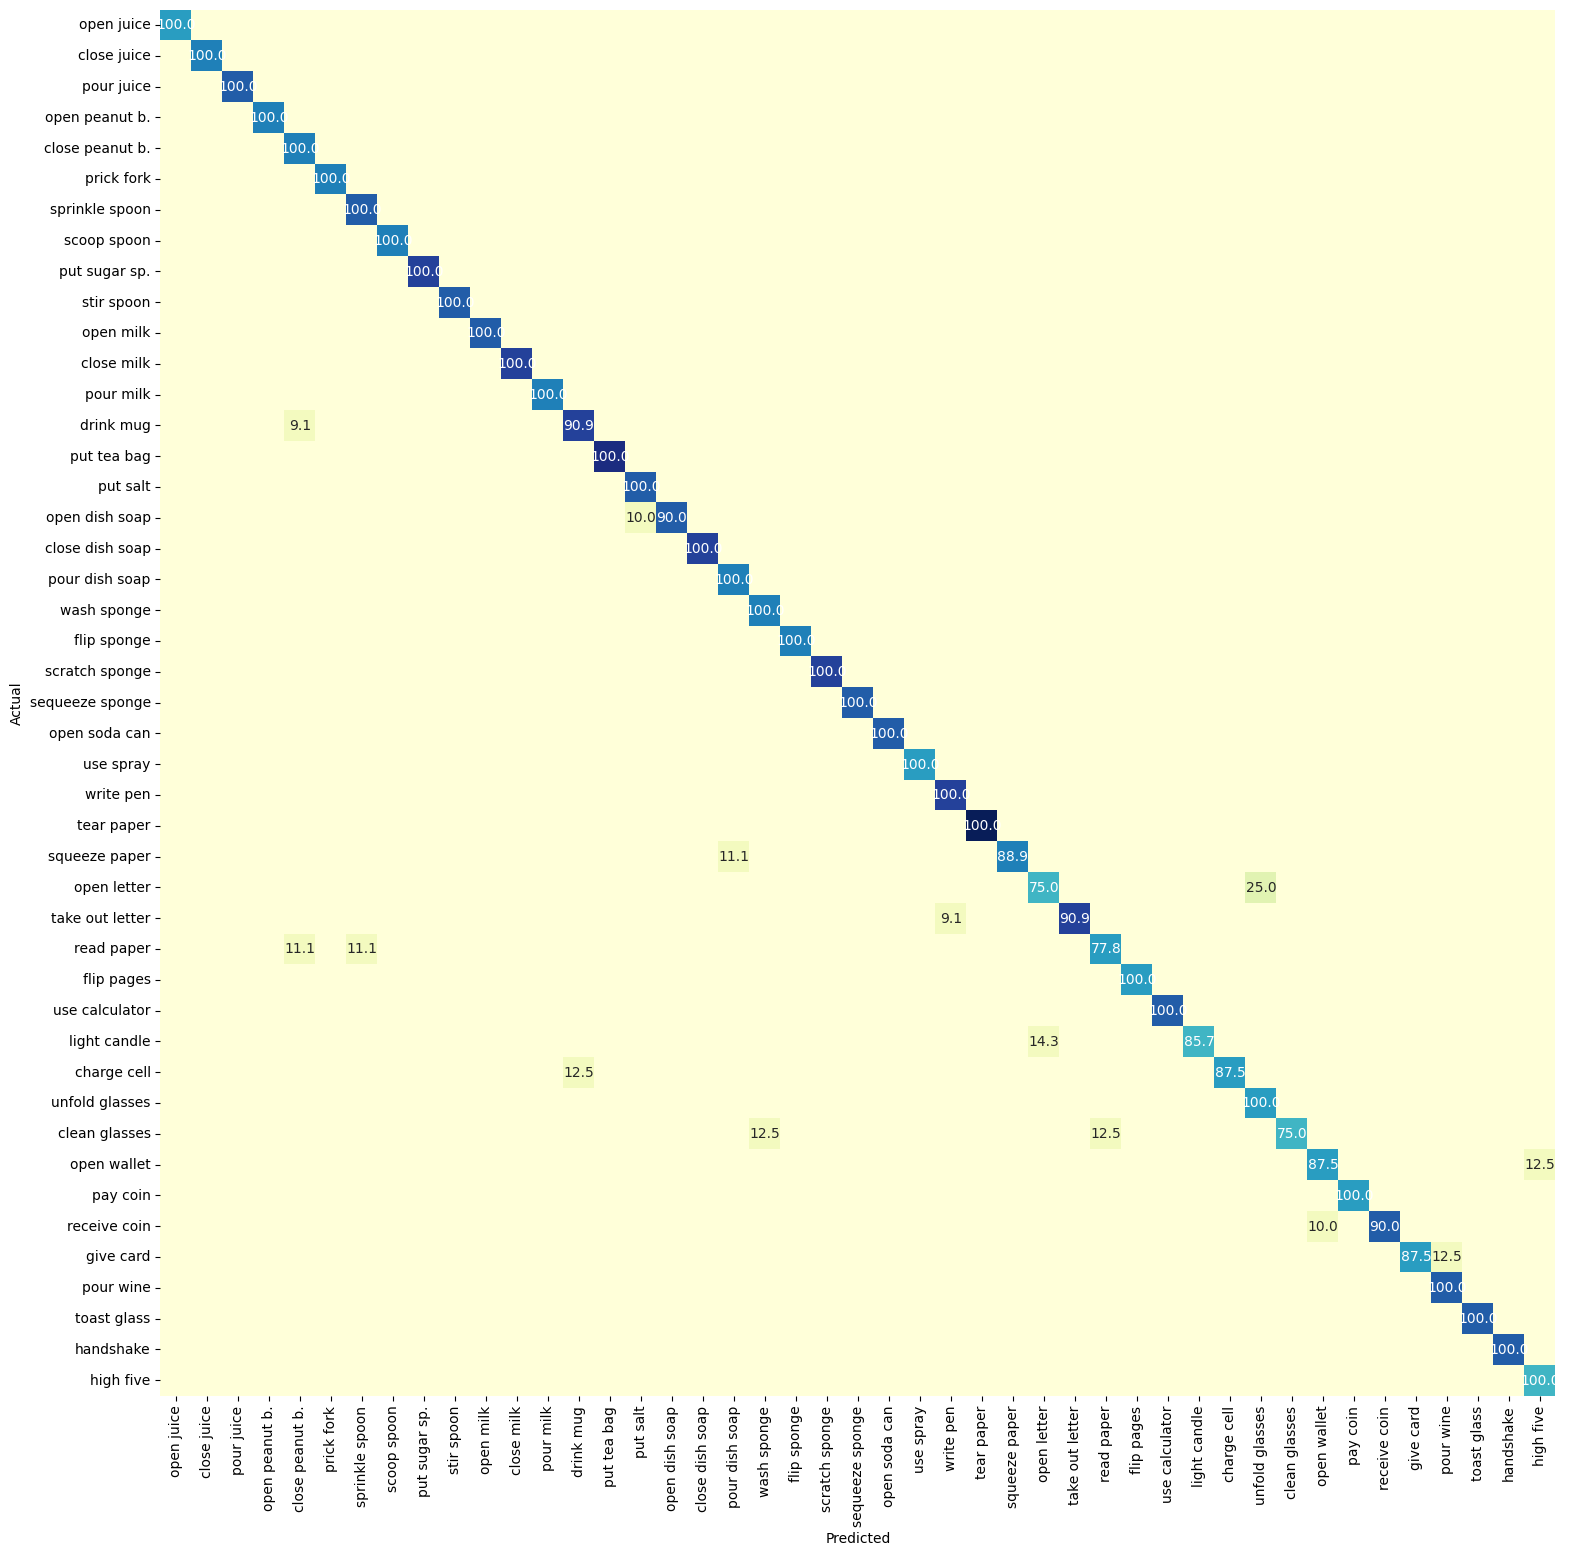

In [44]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test7.png', labels, ymap=None, figsize=(18,18))

### epoch 4

In [45]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 12%|█████                                     | 95/783 [01:06<08:02,  1.43it/s]


 25%|██████████                               | 192/783 [02:12<05:57,  1.65it/s]


 37%|███████████████▏                         | 289/783 [03:20<05:30,  1.49it/s]


 49%|████████████████████▏                    | 386/783 [04:25<04:36,  1.44it/s]


 62%|█████████████████████████▎               | 483/783 [05:32<03:30,  1.42it/s]


 74%|██████████████████████████████▎          | 580/783 [06:39<02:15,  1.50it/s]


 86%|███████████████████████████████████▍     | 677/783 [07:46<01:13,  1.44it/s]


 99%|████████████████████████████████████████▌| 774/783 [08:53<00:06,  1.46it/s]


100%|████████████████████████████████████████████| 1/1 [08:59<00:00, 539.75s/it]


[-24.46875]


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 122.04it/s]


In [46]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 783 samples, validate on 392 samples
Epoch 1/600
783/783 [==============================] - 4s 5ms/step - loss: 0.0309 - accuracy: 0.9987 - val_loss: 0.2300 - val_accuracy: 0.9388
Epoch 2/600
783/783 [==============================] - 0s 136us/step - loss: 0.0407 - accuracy: 1.0000 - val_loss: 0.4134 - val_accuracy: 0.8980
Epoch 3/600
783/783 [==============================] - 0s 113us/step - loss: 0.0444 - accuracy: 0.9949 - val_loss: 0.5387 - val_accuracy: 0.8622
Epoch 4/600
783/783 [==============================] - 0s 129us/step - loss: 0.0409 - accuracy: 0.9974 - val_loss: 0.4516 - val_accuracy: 0.8929
Epoch 5/600
783/783 [==============================] - 0s 129us/step - loss: 0.0604 - accuracy: 0.9872 - val_loss: 0.3529 - val_accuracy: 0.9005
Epoch 6/600
783/783 [==============================] - 0s 132us/step - loss: 0.0476 - accuracy: 0.9962 - val_loss: 0.5239 - val_accuracy: 0.8699
Epoch 7/600
783/783 [==============================] - 0s 120us/step - loss: 0.0689 - 

Epoch 57/600
783/783 [==============================] - 0s 123us/step - loss: 0.0319 - accuracy: 0.9987 - val_loss: 0.1967 - val_accuracy: 0.9439
Epoch 58/600
783/783 [==============================] - 0s 125us/step - loss: 0.0303 - accuracy: 0.9974 - val_loss: 0.1955 - val_accuracy: 0.9439
Epoch 59/600
783/783 [==============================] - 0s 119us/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 0.1940 - val_accuracy: 0.9439
Epoch 60/600
783/783 [==============================] - 0s 125us/step - loss: 0.0371 - accuracy: 0.9949 - val_loss: 0.1932 - val_accuracy: 0.9439
Epoch 61/600
783/783 [==============================] - 0s 125us/step - loss: 0.0305 - accuracy: 0.9987 - val_loss: 0.1924 - val_accuracy: 0.9439
Epoch 62/600
783/783 [==============================] - 0s 123us/step - loss: 0.0287 - accuracy: 0.9987 - val_loss: 0.1916 - val_accuracy: 0.9439
Epoch 63/600
783/783 [==============================] - 0s 134us/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 0.1908 -

783/783 [==============================] - 0s 120us/step - loss: 0.0340 - accuracy: 0.9962 - val_loss: 0.1653 - val_accuracy: 0.9515
Epoch 114/600
783/783 [==============================] - 0s 130us/step - loss: 0.0261 - accuracy: 1.0000 - val_loss: 0.1650 - val_accuracy: 0.9515
Epoch 115/600
783/783 [==============================] - 0s 121us/step - loss: 0.0348 - accuracy: 0.9974 - val_loss: 0.1646 - val_accuracy: 0.9515
Epoch 116/600
783/783 [==============================] - 0s 123us/step - loss: 0.0272 - accuracy: 0.9987 - val_loss: 0.1643 - val_accuracy: 0.9515
Epoch 117/600
783/783 [==============================] - 0s 123us/step - loss: 0.0263 - accuracy: 0.9987 - val_loss: 0.1639 - val_accuracy: 0.9515
Epoch 118/600
783/783 [==============================] - 0s 128us/step - loss: 0.0272 - accuracy: 0.9987 - val_loss: 0.1636 - val_accuracy: 0.9515
Epoch 119/600
783/783 [==============================] - 0s 121us/step - loss: 0.0268 - accuracy: 0.9987 - val_loss: 0.1633 - val_ac

Epoch 169/600
783/783 [==============================] - 0s 120us/step - loss: 0.0372 - accuracy: 0.9962 - val_loss: 0.1525 - val_accuracy: 0.9566
Epoch 170/600
783/783 [==============================] - 0s 120us/step - loss: 0.0295 - accuracy: 0.9974 - val_loss: 0.1524 - val_accuracy: 0.9566
Epoch 171/600
783/783 [==============================] - 0s 122us/step - loss: 0.0357 - accuracy: 0.9962 - val_loss: 0.1522 - val_accuracy: 0.9566
Epoch 172/600
783/783 [==============================] - 0s 122us/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 0.1520 - val_accuracy: 0.9566
Epoch 173/600
783/783 [==============================] - 0s 122us/step - loss: 0.0209 - accuracy: 0.9987 - val_loss: 0.1519 - val_accuracy: 0.9566
Epoch 174/600
783/783 [==============================] - 0s 132us/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.1517 - val_accuracy: 0.9566
Epoch 175/600
783/783 [==============================] - 0s 124us/step - loss: 0.0305 - accuracy: 0.9949 - val_loss: 0

Epoch 225/600
783/783 [==============================] - 0s 123us/step - loss: 0.0290 - accuracy: 0.9987 - val_loss: 0.1467 - val_accuracy: 0.9592
Epoch 226/600
783/783 [==============================] - 0s 132us/step - loss: 0.0335 - accuracy: 0.9974 - val_loss: 0.1467 - val_accuracy: 0.9592
Epoch 227/600
783/783 [==============================] - 0s 117us/step - loss: 0.0257 - accuracy: 0.9987 - val_loss: 0.1467 - val_accuracy: 0.9592
Epoch 228/600
783/783 [==============================] - 0s 120us/step - loss: 0.0317 - accuracy: 0.9987 - val_loss: 0.1467 - val_accuracy: 0.9592
Epoch 229/600
783/783 [==============================] - 0s 139us/step - loss: 0.0286 - accuracy: 0.9974 - val_loss: 0.1467 - val_accuracy: 0.9592
Epoch 230/600
783/783 [==============================] - 0s 139us/step - loss: 0.0269 - accuracy: 0.9987 - val_loss: 0.1466 - val_accuracy: 0.9592
Epoch 231/600
783/783 [==============================] - 0s 130us/step - loss: 0.0228 - accuracy: 0.9987 - val_loss: 0

Epoch 281/600
783/783 [==============================] - 0s 126us/step - loss: 0.0385 - accuracy: 0.9962 - val_loss: 0.1454 - val_accuracy: 0.9592
Epoch 282/600
783/783 [==============================] - 0s 139us/step - loss: 0.0280 - accuracy: 0.9987 - val_loss: 0.1454 - val_accuracy: 0.9592
Epoch 283/600
783/783 [==============================] - 0s 147us/step - loss: 0.0279 - accuracy: 0.9974 - val_loss: 0.1453 - val_accuracy: 0.9592
Epoch 284/600
783/783 [==============================] - 0s 136us/step - loss: 0.0350 - accuracy: 0.9962 - val_loss: 0.1452 - val_accuracy: 0.9592
Epoch 285/600
783/783 [==============================] - 0s 139us/step - loss: 0.0323 - accuracy: 0.9974 - val_loss: 0.1452 - val_accuracy: 0.9592
Epoch 286/600
783/783 [==============================] - 0s 137us/step - loss: 0.0288 - accuracy: 0.9962 - val_loss: 0.1451 - val_accuracy: 0.9592
Epoch 287/600
783/783 [==============================] - 0s 136us/step - loss: 0.0324 - accuracy: 0.9962 - val_loss: 0

Epoch 337/600
783/783 [==============================] - 0s 134us/step - loss: 0.0250 - accuracy: 0.9987 - val_loss: 0.1441 - val_accuracy: 0.9592
Epoch 338/600
783/783 [==============================] - 0s 130us/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.1441 - val_accuracy: 0.9592
Epoch 339/600
783/783 [==============================] - 0s 119us/step - loss: 0.0260 - accuracy: 1.0000 - val_loss: 0.1440 - val_accuracy: 0.9592
Epoch 340/600
783/783 [==============================] - 0s 135us/step - loss: 0.0270 - accuracy: 0.9987 - val_loss: 0.1438 - val_accuracy: 0.9592
Epoch 341/600
783/783 [==============================] - 0s 123us/step - loss: 0.0227 - accuracy: 0.9987 - val_loss: 0.1437 - val_accuracy: 0.9592
Epoch 342/600
783/783 [==============================] - 0s 118us/step - loss: 0.0276 - accuracy: 0.9987 - val_loss: 0.1436 - val_accuracy: 0.9592
Epoch 343/600
783/783 [==============================] - 0s 131us/step - loss: 0.0269 - accuracy: 0.9987 - val_loss: 0

Epoch 393/600
783/783 [==============================] - 0s 126us/step - loss: 0.0292 - accuracy: 0.9987 - val_loss: 0.1398 - val_accuracy: 0.9592
Epoch 394/600
783/783 [==============================] - 0s 125us/step - loss: 0.0281 - accuracy: 0.9987 - val_loss: 0.1398 - val_accuracy: 0.9592
Epoch 395/600
783/783 [==============================] - 0s 122us/step - loss: 0.0326 - accuracy: 0.9974 - val_loss: 0.1397 - val_accuracy: 0.9592
Epoch 396/600
783/783 [==============================] - 0s 134us/step - loss: 0.0257 - accuracy: 0.9987 - val_loss: 0.1397 - val_accuracy: 0.9592
Epoch 397/600
783/783 [==============================] - 0s 121us/step - loss: 0.0243 - accuracy: 0.9987 - val_loss: 0.1396 - val_accuracy: 0.9592
Epoch 398/600
783/783 [==============================] - 0s 124us/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.1395 - val_accuracy: 0.9592
Epoch 399/600
783/783 [==============================] - 0s 123us/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0

Epoch 449/600
783/783 [==============================] - 0s 127us/step - loss: 0.0244 - accuracy: 0.9987 - val_loss: 0.1405 - val_accuracy: 0.9592
Epoch 450/600
783/783 [==============================] - 0s 124us/step - loss: 0.0333 - accuracy: 0.9974 - val_loss: 0.1404 - val_accuracy: 0.9592
Epoch 451/600
783/783 [==============================] - 0s 120us/step - loss: 0.0253 - accuracy: 0.9987 - val_loss: 0.1404 - val_accuracy: 0.9592
Epoch 452/600
783/783 [==============================] - 0s 145us/step - loss: 0.0301 - accuracy: 0.9974 - val_loss: 0.1404 - val_accuracy: 0.9592
Epoch 453/600
783/783 [==============================] - 0s 137us/step - loss: 0.0289 - accuracy: 0.9987 - val_loss: 0.1404 - val_accuracy: 0.9592
Epoch 454/600
783/783 [==============================] - 0s 122us/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 0.9592
Epoch 455/600
783/783 [==============================] - 0s 124us/step - loss: 0.0245 - accuracy: 0.9987 - val_loss: 0

Epoch 505/600
783/783 [==============================] - 0s 130us/step - loss: 0.0284 - accuracy: 0.9987 - val_loss: 0.1413 - val_accuracy: 0.9592
Epoch 506/600
783/783 [==============================] - 0s 125us/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.1412 - val_accuracy: 0.9592
Epoch 507/600
783/783 [==============================] - 0s 136us/step - loss: 0.0288 - accuracy: 0.9974 - val_loss: 0.1413 - val_accuracy: 0.9592
Epoch 508/600
783/783 [==============================] - 0s 129us/step - loss: 0.0266 - accuracy: 0.9974 - val_loss: 0.1413 - val_accuracy: 0.9592
Epoch 509/600
783/783 [==============================] - 0s 120us/step - loss: 0.0269 - accuracy: 1.0000 - val_loss: 0.1414 - val_accuracy: 0.9592
Epoch 510/600
783/783 [==============================] - 0s 126us/step - loss: 0.0291 - accuracy: 0.9987 - val_loss: 0.1414 - val_accuracy: 0.9592
Epoch 511/600
783/783 [==============================] - 0s 121us/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0

Epoch 561/600
783/783 [==============================] - 0s 126us/step - loss: 0.0301 - accuracy: 0.9974 - val_loss: 0.1416 - val_accuracy: 0.9592
Epoch 562/600
783/783 [==============================] - 0s 135us/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.1416 - val_accuracy: 0.9592
Epoch 563/600
783/783 [==============================] - 0s 119us/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.1417 - val_accuracy: 0.9592
Epoch 564/600
783/783 [==============================] - 0s 121us/step - loss: 0.0302 - accuracy: 0.9974 - val_loss: 0.1417 - val_accuracy: 0.9592
Epoch 565/600
783/783 [==============================] - 0s 122us/step - loss: 0.0280 - accuracy: 0.9987 - val_loss: 0.1416 - val_accuracy: 0.9592
Epoch 566/600
783/783 [==============================] - 0s 131us/step - loss: 0.0242 - accuracy: 0.9962 - val_loss: 0.1416 - val_accuracy: 0.9592
Epoch 567/600
783/783 [==============================] - 0s 124us/step - loss: 0.0288 - accuracy: 0.9987 - val_loss: 0

In [47]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9566326530612245


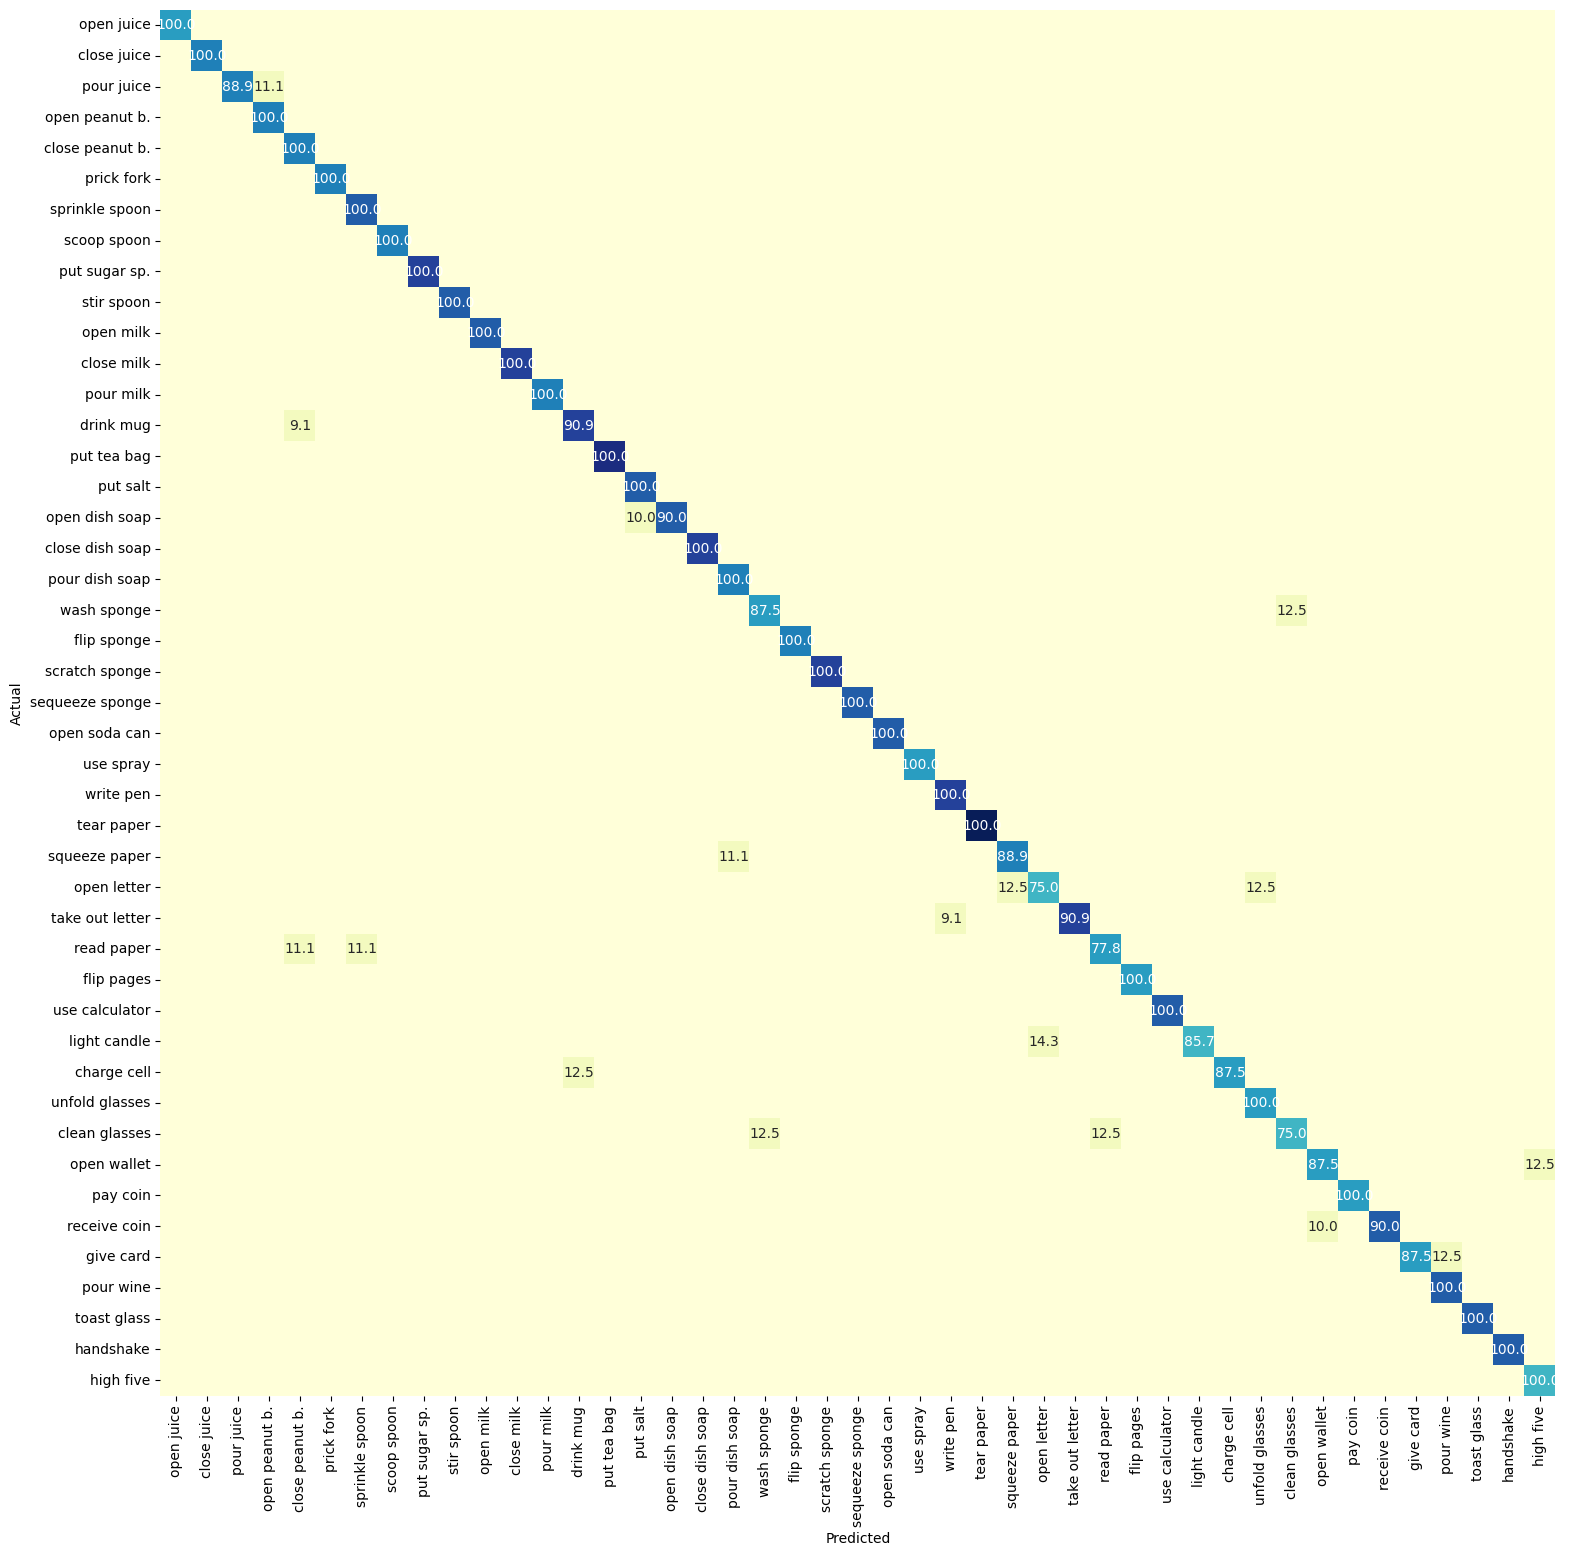

In [48]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test8.png', labels, ymap=None, figsize=(18,18))

### epoch 5

In [49]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 12%|█████                                     | 95/783 [01:06<07:48,  1.47it/s]


 25%|██████████                               | 192/783 [02:14<06:46,  1.45it/s]


 37%|███████████████▏                         | 289/783 [03:21<05:37,  1.46it/s]


 49%|████████████████████▏                    | 386/783 [04:29<04:39,  1.42it/s]


 62%|█████████████████████████▎               | 483/783 [05:37<03:34,  1.40it/s]


 74%|██████████████████████████████▎          | 580/783 [06:45<02:22,  1.42it/s]


 86%|███████████████████████████████████▍     | 677/783 [07:53<01:15,  1.40it/s]


 99%|████████████████████████████████████████▌| 774/783 [09:02<00:06,  1.40it/s]


100%|████████████████████████████████████████████| 1/1 [09:08<00:00, 548.64s/it]


[-24.46875]


100%|████████████████████████████████████████| 783/783 [00:06<00:00, 120.24it/s]


In [50]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 783 samples, validate on 392 samples
Epoch 1/600
783/783 [==============================] - 4s 5ms/step - loss: 0.0274 - accuracy: 0.9987 - val_loss: 0.1705 - val_accuracy: 0.9541
Epoch 2/600
783/783 [==============================] - 0s 134us/step - loss: 0.0267 - accuracy: 0.9987 - val_loss: 0.2469 - val_accuracy: 0.9311
Epoch 3/600
783/783 [==============================] - 0s 118us/step - loss: 0.0439 - accuracy: 0.9974 - val_loss: 0.2934 - val_accuracy: 0.9362
Epoch 4/600
783/783 [==============================] - 0s 117us/step - loss: 0.0403 - accuracy: 0.9936 - val_loss: 0.4338 - val_accuracy: 0.8903
Epoch 5/600
783/783 [==============================] - 0s 118us/step - loss: 0.0568 - accuracy: 0.9911 - val_loss: 0.5079 - val_accuracy: 0.8673
Epoch 6/600
783/783 [==============================] - 0s 118us/step - loss: 0.0406 - accuracy: 0.9962 - val_loss: 0.4850 - val_accuracy: 0.8801
Epoch 7/600
783/783 [==============================] - 0s 118us/step - loss: 0.0530 - 

Epoch 57/600
783/783 [==============================] - 0s 121us/step - loss: 0.0288 - accuracy: 0.9974 - val_loss: 0.1812 - val_accuracy: 0.9439
Epoch 58/600
783/783 [==============================] - 0s 121us/step - loss: 0.0273 - accuracy: 0.9949 - val_loss: 0.1783 - val_accuracy: 0.9439
Epoch 59/600
783/783 [==============================] - 0s 129us/step - loss: 0.0229 - accuracy: 0.9987 - val_loss: 0.1753 - val_accuracy: 0.9464
Epoch 60/600
783/783 [==============================] - 0s 115us/step - loss: 0.0239 - accuracy: 0.9987 - val_loss: 0.1730 - val_accuracy: 0.9439
Epoch 61/600
783/783 [==============================] - 0s 117us/step - loss: 0.0211 - accuracy: 0.9987 - val_loss: 0.1706 - val_accuracy: 0.9515
Epoch 62/600
783/783 [==============================] - 0s 120us/step - loss: 0.0244 - accuracy: 0.9987 - val_loss: 0.1682 - val_accuracy: 0.9490
Epoch 63/600
783/783 [==============================] - 0s 121us/step - loss: 0.0228 - accuracy: 0.9987 - val_loss: 0.1659 -

783/783 [==============================] - 0s 127us/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.1323 - val_accuracy: 0.9668
Epoch 114/600
783/783 [==============================] - 0s 130us/step - loss: 0.0238 - accuracy: 0.9987 - val_loss: 0.1323 - val_accuracy: 0.9643
Epoch 115/600
783/783 [==============================] - 0s 127us/step - loss: 0.0276 - accuracy: 0.9962 - val_loss: 0.1324 - val_accuracy: 0.9643
Epoch 116/600
783/783 [==============================] - 0s 129us/step - loss: 0.0316 - accuracy: 0.9936 - val_loss: 0.1324 - val_accuracy: 0.9643
Epoch 117/600
783/783 [==============================] - 0s 123us/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.1324 - val_accuracy: 0.9643
Epoch 118/600
783/783 [==============================] - 0s 130us/step - loss: 0.0201 - accuracy: 0.9974 - val_loss: 0.1324 - val_accuracy: 0.9617
Epoch 119/600
783/783 [==============================] - 0s 121us/step - loss: 0.0239 - accuracy: 0.9962 - val_loss: 0.1324 - val_ac

Epoch 169/600
783/783 [==============================] - 0s 149us/step - loss: 0.0229 - accuracy: 0.9987 - val_loss: 0.1372 - val_accuracy: 0.9617
Epoch 170/600
783/783 [==============================] - 0s 130us/step - loss: 0.0267 - accuracy: 0.9962 - val_loss: 0.1373 - val_accuracy: 0.9617
Epoch 171/600
783/783 [==============================] - 0s 135us/step - loss: 0.0283 - accuracy: 0.9974 - val_loss: 0.1374 - val_accuracy: 0.9617
Epoch 172/600
783/783 [==============================] - 0s 134us/step - loss: 0.0256 - accuracy: 1.0000 - val_loss: 0.1374 - val_accuracy: 0.9617
Epoch 173/600
783/783 [==============================] - 0s 131us/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.1375 - val_accuracy: 0.9617
Epoch 174/600
783/783 [==============================] - 0s 131us/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.1375 - val_accuracy: 0.9617
Epoch 175/600
783/783 [==============================] - 0s 134us/step - loss: 0.0210 - accuracy: 0.9974 - val_loss: 0

Epoch 225/600
783/783 [==============================] - 0s 134us/step - loss: 0.0247 - accuracy: 0.9974 - val_loss: 0.1402 - val_accuracy: 0.9617
Epoch 226/600
783/783 [==============================] - 0s 143us/step - loss: 0.0236 - accuracy: 0.9974 - val_loss: 0.1401 - val_accuracy: 0.9617
Epoch 227/600
783/783 [==============================] - 0s 142us/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.1401 - val_accuracy: 0.9617
Epoch 228/600
783/783 [==============================] - 0s 139us/step - loss: 0.0281 - accuracy: 0.9974 - val_loss: 0.1401 - val_accuracy: 0.9617
Epoch 229/600
783/783 [==============================] - 0s 132us/step - loss: 0.0206 - accuracy: 0.9987 - val_loss: 0.1400 - val_accuracy: 0.9617
Epoch 230/600
783/783 [==============================] - 0s 132us/step - loss: 0.0225 - accuracy: 0.9974 - val_loss: 0.1400 - val_accuracy: 0.9617
Epoch 231/600
783/783 [==============================] - 0s 131us/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0

Epoch 281/600
783/783 [==============================] - 0s 127us/step - loss: 0.0176 - accuracy: 0.9987 - val_loss: 0.1397 - val_accuracy: 0.9617
Epoch 282/600
783/783 [==============================] - 0s 126us/step - loss: 0.0243 - accuracy: 0.9962 - val_loss: 0.1397 - val_accuracy: 0.9617
Epoch 283/600
783/783 [==============================] - 0s 133us/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.1397 - val_accuracy: 0.9617
Epoch 284/600
783/783 [==============================] - 0s 130us/step - loss: 0.0258 - accuracy: 0.9974 - val_loss: 0.1398 - val_accuracy: 0.9617
Epoch 285/600
783/783 [==============================] - 0s 134us/step - loss: 0.0237 - accuracy: 0.9987 - val_loss: 0.1398 - val_accuracy: 0.9617
Epoch 286/600
783/783 [==============================] - 0s 130us/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.1398 - val_accuracy: 0.9617
Epoch 287/600
783/783 [==============================] - 0s 128us/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0

Epoch 337/600
783/783 [==============================] - 0s 133us/step - loss: 0.0215 - accuracy: 0.9987 - val_loss: 0.1425 - val_accuracy: 0.9617
Epoch 338/600
783/783 [==============================] - 0s 131us/step - loss: 0.0220 - accuracy: 0.9987 - val_loss: 0.1426 - val_accuracy: 0.9617
Epoch 339/600
783/783 [==============================] - 0s 132us/step - loss: 0.0201 - accuracy: 0.9987 - val_loss: 0.1426 - val_accuracy: 0.9617
Epoch 340/600
783/783 [==============================] - 0s 138us/step - loss: 0.0256 - accuracy: 0.9987 - val_loss: 0.1426 - val_accuracy: 0.9617
Epoch 341/600
783/783 [==============================] - 0s 137us/step - loss: 0.0202 - accuracy: 0.9987 - val_loss: 0.1427 - val_accuracy: 0.9617
Epoch 342/600
783/783 [==============================] - 0s 136us/step - loss: 0.0252 - accuracy: 0.9987 - val_loss: 0.1427 - val_accuracy: 0.9617
Epoch 343/600
783/783 [==============================] - 0s 132us/step - loss: 0.0250 - accuracy: 0.9987 - val_loss: 0

Epoch 393/600
783/783 [==============================] - 0s 168us/step - loss: 0.0251 - accuracy: 0.9987 - val_loss: 0.1438 - val_accuracy: 0.9617
Epoch 394/600
783/783 [==============================] - 0s 132us/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.1439 - val_accuracy: 0.9617
Epoch 395/600
783/783 [==============================] - 0s 126us/step - loss: 0.0233 - accuracy: 0.9987 - val_loss: 0.1439 - val_accuracy: 0.9617
Epoch 396/600
783/783 [==============================] - 0s 132us/step - loss: 0.0222 - accuracy: 0.9974 - val_loss: 0.1439 - val_accuracy: 0.9617
Epoch 397/600
783/783 [==============================] - 0s 129us/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.1440 - val_accuracy: 0.9617
Epoch 398/600
783/783 [==============================] - 0s 133us/step - loss: 0.0231 - accuracy: 0.9962 - val_loss: 0.1440 - val_accuracy: 0.9617
Epoch 399/600
783/783 [==============================] - 0s 131us/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0

Epoch 449/600
783/783 [==============================] - 0s 129us/step - loss: 0.0201 - accuracy: 0.9987 - val_loss: 0.1417 - val_accuracy: 0.9617
Epoch 450/600
783/783 [==============================] - 0s 129us/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.1418 - val_accuracy: 0.9617
Epoch 451/600
783/783 [==============================] - 0s 129us/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.1418 - val_accuracy: 0.9617
Epoch 452/600
783/783 [==============================] - 0s 133us/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.1418 - val_accuracy: 0.9617
Epoch 453/600
783/783 [==============================] - 0s 130us/step - loss: 0.0223 - accuracy: 0.9987 - val_loss: 0.1418 - val_accuracy: 0.9617
Epoch 454/600
783/783 [==============================] - 0s 132us/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.1418 - val_accuracy: 0.9617
Epoch 455/600
783/783 [==============================] - 0s 129us/step - loss: 0.0226 - accuracy: 0.9987 - val_loss: 0

Epoch 505/600
783/783 [==============================] - 0s 129us/step - loss: 0.0239 - accuracy: 0.9987 - val_loss: 0.1409 - val_accuracy: 0.9617
Epoch 506/600
783/783 [==============================] - 0s 138us/step - loss: 0.0186 - accuracy: 0.9987 - val_loss: 0.1408 - val_accuracy: 0.9617
Epoch 507/600
783/783 [==============================] - 0s 143us/step - loss: 0.0296 - accuracy: 0.9974 - val_loss: 0.1408 - val_accuracy: 0.9617
Epoch 508/600
783/783 [==============================] - 0s 131us/step - loss: 0.0214 - accuracy: 0.9974 - val_loss: 0.1408 - val_accuracy: 0.9617
Epoch 509/600
783/783 [==============================] - 0s 131us/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.1408 - val_accuracy: 0.9617
Epoch 510/600
783/783 [==============================] - 0s 132us/step - loss: 0.0275 - accuracy: 0.9962 - val_loss: 0.1409 - val_accuracy: 0.9617
Epoch 511/600
783/783 [==============================] - 0s 135us/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0

Epoch 561/600
783/783 [==============================] - 0s 128us/step - loss: 0.0204 - accuracy: 0.9974 - val_loss: 0.1391 - val_accuracy: 0.9617
Epoch 562/600
783/783 [==============================] - 0s 130us/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.1390 - val_accuracy: 0.9617
Epoch 563/600
783/783 [==============================] - 0s 129us/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.1390 - val_accuracy: 0.9617
Epoch 564/600
783/783 [==============================] - 0s 128us/step - loss: 0.0209 - accuracy: 0.9987 - val_loss: 0.1389 - val_accuracy: 0.9617
Epoch 565/600
783/783 [==============================] - 0s 128us/step - loss: 0.0261 - accuracy: 0.9987 - val_loss: 0.1388 - val_accuracy: 0.9617
Epoch 566/600
783/783 [==============================] - 0s 128us/step - loss: 0.0225 - accuracy: 0.9962 - val_loss: 0.1388 - val_accuracy: 0.9617
Epoch 567/600
783/783 [==============================] - 0s 125us/step - loss: 0.0180 - accuracy: 0.9974 - val_loss: 0

In [51]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9642857142857143


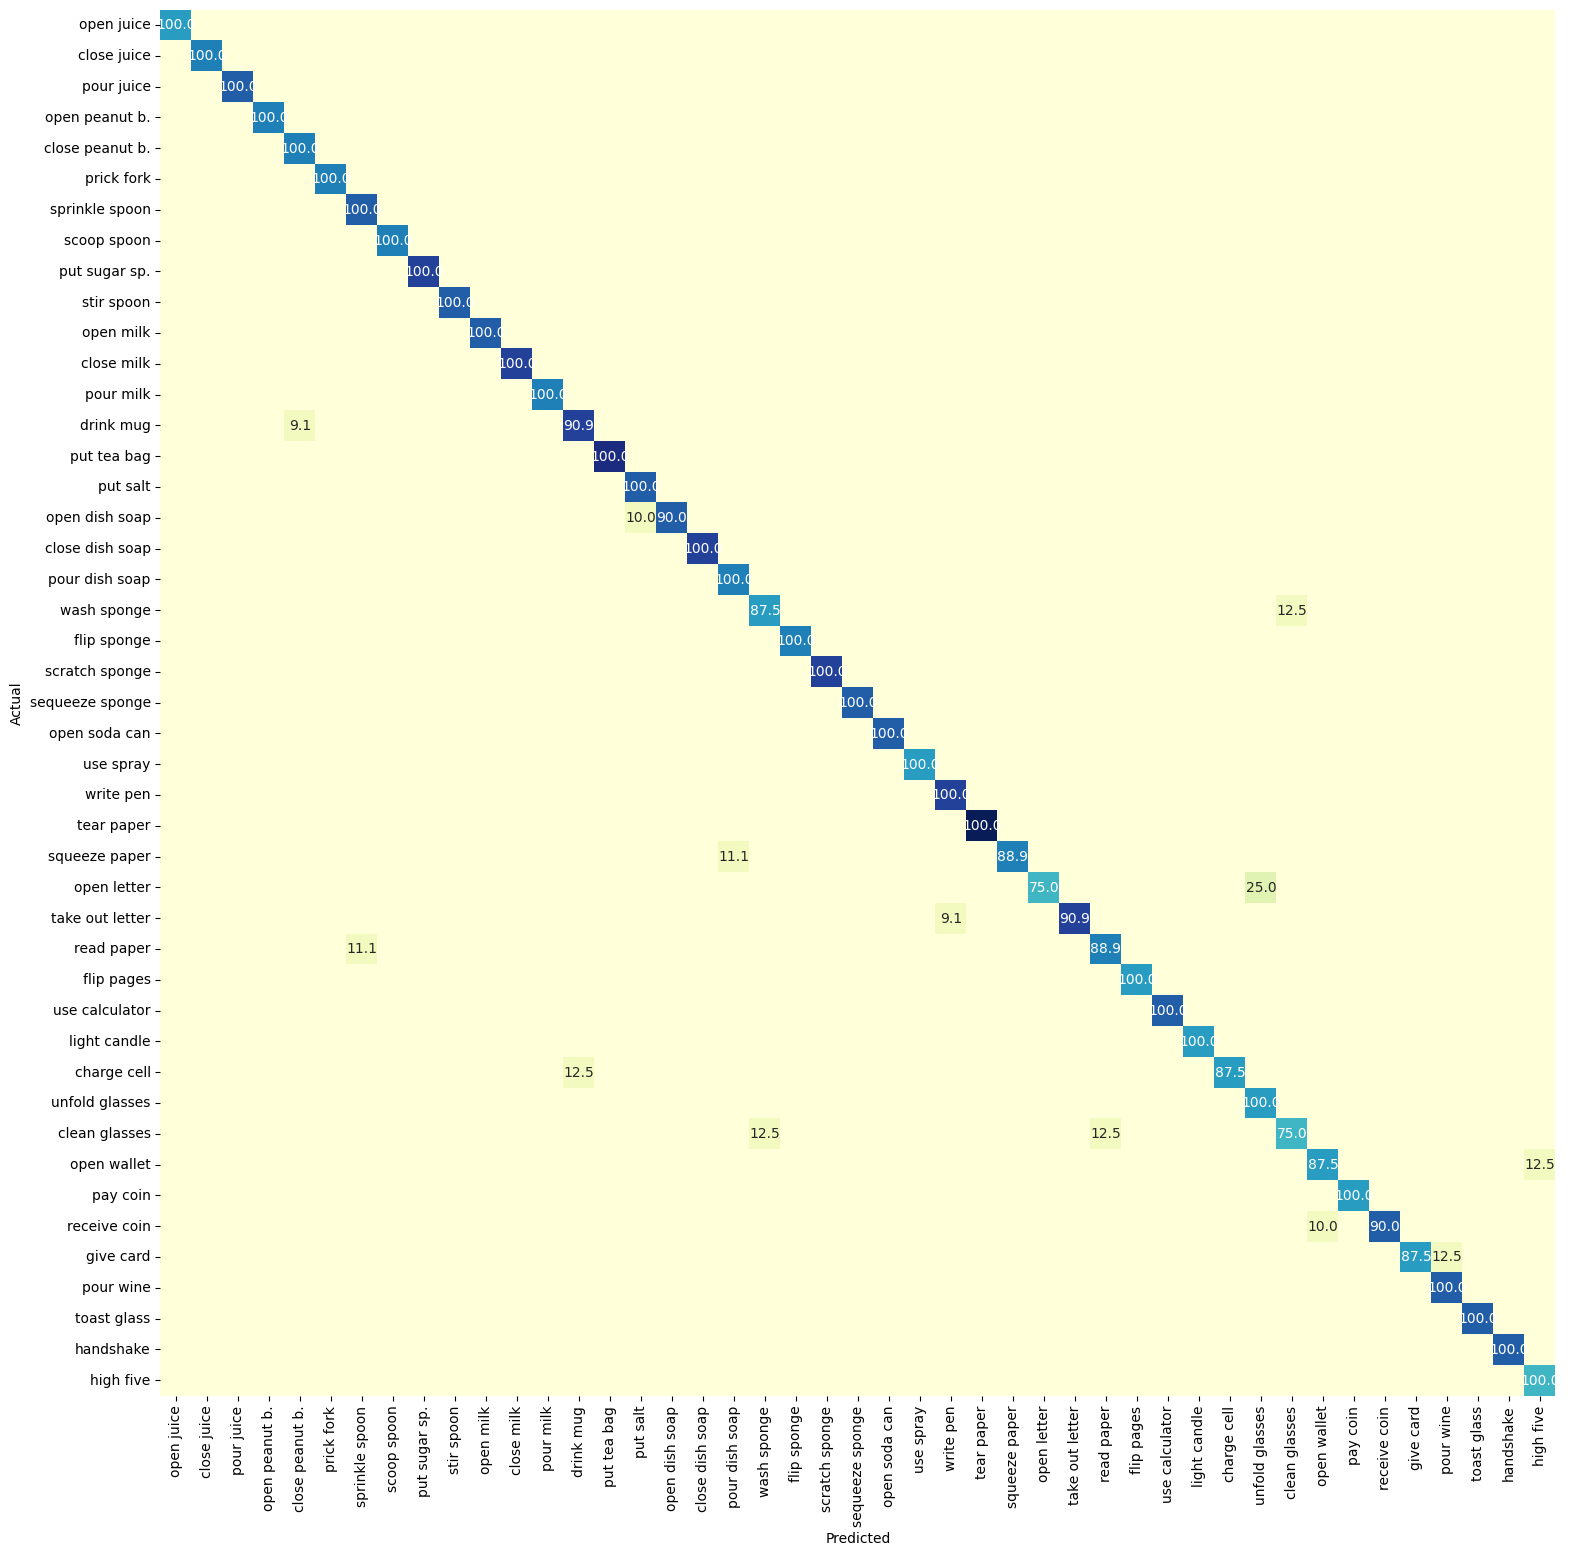

In [52]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_310_test9.png', labels, ymap=None, figsize=(18,18))

In [ ]:
end